- **This code computes the decomposed solution of a Closed-Loop DRTO problem.**
- Using economic objective function
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC N.B.:strategy 2 not working
- The problem is posed as a scenario-based stochastic programming problem
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames, Distributions, LaTeXStrings

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # for tight constraints: 1.9 | for loose constraints: 5.0 or 10.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building affine CL-DRTO models

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

CL-DRTO configuration

In [4]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1)# p = 8 *controller horizon  
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

DRTO model changes with the number of scenarios and parallel reactors

In [5]:
function DRTO_matrices(nReactors,nScenarios)
    # ATTENTION: Used for the monolithic solution. Generates an array of models
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the models based on a fixed index grid that is generated based on the number of scenarios
    
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors])
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

In [6]:
function DRTO_matrix(nReactors,nScenario,nScenTotal)
    # ATTENTION: Used for the decomposed solution. Generates a single model
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the model of interest based on the index "nScenario"
  
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenario - index the of scenario used in the stochastic optimization
    # nScenTotal - total number of scenario used in the stochastic optimization
    
    if nScenTotal == 1
        index_temp = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenTotal-1)) for ii in 1:nScenTotal]
        index_temp = indexScen[nScenario]
    end
  
    # building DRTO model
    A_drto = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
    B_drto = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

# Building MPC model

Controller configuration

In [7]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

Notes:
- Using nominal model(indexScen = 50)
- For the description of how the MPC matrices (with disturbance model) are built, check script: *CLDRTO with unconstrained MPC - uncertain plant test*

In [8]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

# Solving CL-DRTO Multiscenario Problem (monolithic)
 - Check details in script *Monolithic CLDRTO*
 - For the description of the different solution strategies, check *Different Strategies to solve constrained MPC within CLDRTO*

In [9]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 1000
bigM_u = 100

# weight complementarity relaxation OF term
pi_bar = 10^3;

In [10]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)

    # Define model
    if option == 3 || option == 1
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
    if option == 1
        @variable(model_ms, u_w_c[1:pD,1:m,1:nScen]) # inputs w/o clipping
    
        # input clipping 
        @variable(model_ms, mu_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, mu_ub[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_ub[1:pD,1:m,1:nScen] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################    
    if option == 1
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u_w_c[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])
        
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u_w_c[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u_w_c[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping
        @constraint(model_ms, ic_1[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] == u_w_c[kk,uu,ss] - mu_ub[kk,uu,ss] + mu_lb[kk,uu,ss])
        @constraint(model_ms, ic_2[kk = 1:mD,uu = 1:m,ss = 1:nScen], (uMax - u0) - u[kk,uu,ss] == eta_ub[kk,uu,ss])
        @constraint(model_ms, ic_3[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_ub[kk,uu,ss]*mu_ub[kk,uu,ss] ≤ 1e-6)
        @constraint(model_ms, ic_4[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] - (uMin - u0) == eta_lb[kk,uu,ss])
        @constraint(model_ms, ic_5[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_lb[kk,uu,ss]*mu_lb[kk,uu,ss] ≤ 1e-6)
        
    elseif option == 2
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
        # Expressions for OF
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
    end
        
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum(-yDRTO[kk,ss] + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum(-yDRTO[kk,ss] + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    #set_optimizer_attribute(model_ms, "CPX_PARAM_BARALG", 1)
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xDRTOArray,
                        'c' => yDRTOArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

# Decomposition of CLDRTO Problem

<div>
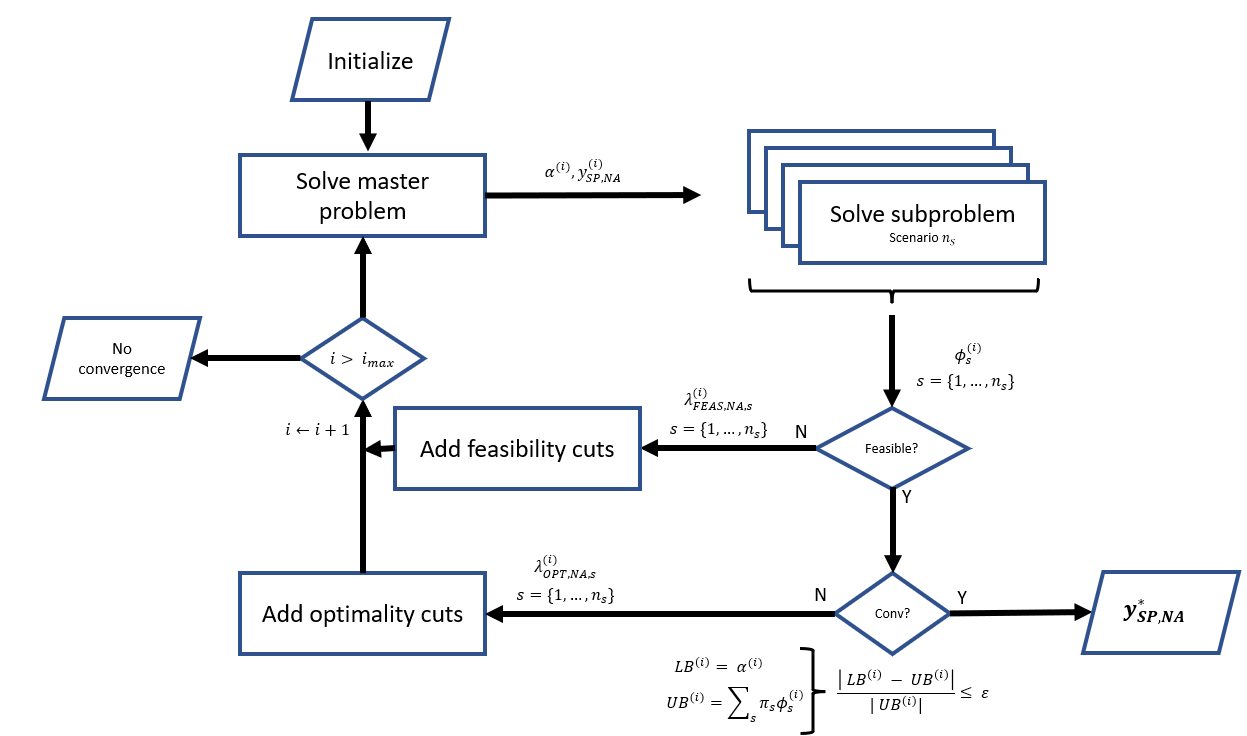
</div>

## Modeling Subproblem

In [11]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - setpoints fixed by the Master Problem --> nonanticipativity constraints
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC 
        # for now, code only works for option = 3

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    
    # recomputing the number of total scenarios based on scenario probability and the fact that the scenarios have the same probability
    nScenTotal = ceil(Int,1/pScen)    
    drto = DRTO_matrix(nReac,nScen,nScenTotal)
    
    # Define subproblem model  #== 3
    if option == 3 || option == 1
        sub = Model(Ipopt.Optimizer)
        set_optimizer_attribute(sub, "max_cpu_time", 300.0) # 5 min
    else 
        sub = Model(CPLEX.Optimizer)
        set_optimizer_attribute(sub, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(sub) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])
    if option == 1
        @variable(sub, u_w_c[1:pD,1:m]) # inputs w/o clipping
    
        # input clipping 
        @variable(sub, mu_lb[1:pD,1:m] ≥ 0)
        @variable(sub, eta_lb[1:pD,1:m] ≥ 0)
        @variable(sub, mu_ub[1:pD,1:m] ≥ 0)
        @variable(sub, eta_ub[1:pD,1:m] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
        
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_p[1:pD] ≥ 0)
    
    if option == 2 || option == 3
        @variable(sub, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(sub, Y_lb[1:mD,1:m], start = 0) # Relaxing binaries for big-M implementation
        @variable(sub, Y_ub[1:mD,1:m], start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:pD
            set_start_value(yDRTO[ii], solNom['y'][ii,1]) 
            set_start_value(yMPC[ii], solNom['c'][ii,1])
            #set_start_value(ysp[ii], solNom['s'][ii,1])

            for rr in 1:nReac # when nReac increases, the number of states change!
                for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                    set_start_value(xDRTO[ii,xx + (rr - 1)*2], solNom['x'][ii,xx,1])    
                    set_start_value(xMPC[ii,xx + (rr - 1)*2], solNom['m'][ii,xx,1])           
                end # end xx
            end # number 
                
            for uu in 1:m
                set_start_value(u[ii,uu], solNom['u'][ii,uu,1])
            end # end of uu
        end # eend of ii
    end # end of if

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== drto['A']*xInit + drto['B']*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== drto['A']*xDRTO[kk,:] + drto['B']*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == dot(drto['C'],xDRTO[kk,:]))

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # P soft constraints
    @constraint(sub, soft_P[kk=1:pD], yDRTO[kk] - delta_p[kk] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################ 
    if option == 1
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u_w_c[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Unconstrained MPC solution  
        @constraint(sub, MPC_sol_1, mpc['H']*u_w_c[1,:] + cfT_1' .== 0)
        @constraint(sub, MPC_sol[kk=2:mD],mpc['H']*u_w_c[kk,:] + cfT[kk]' .== 0)

        # input clipping
        @constraint(sub, ic_1[kk = 1:mD,uu = 1:m], u[kk,uu] == u_w_c[kk,uu] - mu_ub[kk,uu] + mu_lb[kk,uu])
        @constraint(sub, ic_2[kk = 1:mD,uu = 1:m], (uMax - u0) - u[kk,uu] == eta_ub[kk,uu])
        @constraint(sub, ic_3[kk = 1:mD,uu = 1:m], eta_ub[kk,uu]*mu_ub[kk,uu] ≤ 1e-6)
        @constraint(sub, ic_4[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMin - u0) == eta_lb[kk,uu])
        @constraint(sub, ic_5[kk = 1:mD,uu = 1:m], eta_lb[kk,uu]*mu_lb[kk,uu] ≤ 1e-6)

    
    elseif option == 2
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] ≤ bigM_mu*Y_ub[kk,uu])
        @constraint(sub, bigM_2[kk=1:mD,uu=1:m], mu_g[kk,uu + m] ≤ bigM_mu*Y_lb[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu]))
        @constraint(sub, bigM_4[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≥ -bigM_u*(1 - Y_lb[kk,uu]))
        
        @constraint(sub, compSlack[kk=1:mD,uu=1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    elseif option == 3
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility       
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
        
        # expression to be used in OF        
        @expression(sub, g_u_u[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0))
        @expression(sub, g_u_l[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu])
        
    end
  
    #############################
    # Set up objective function #
    #############################
     if option == 1 || option == 2
        @objective(sub, Min, 
            pScen*sum(-yDRTO[kk] + wP*delta_p[kk]^2 for kk in 1:pD)
        )
    else
        @objective(sub, Min, 
            pScen*sum(-yDRTO[kk] + wP*delta_p[kk]^2 for kk in 1:pD)
                    - pScen*pi_bar*sum(
                                    sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                                    sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                                for kk = 1:mD)
        )
    end
    
    # @show sub
    #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)
    
    optimize!(sub)
    
    # solution time
    timeSol = solve_time(sub)
    
    status = termination_status(sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)

        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
        # if binaries are used for solving const. MPC
        if option == 2
            muArray = value.(mu_g)
                   
            uubBinArray = value.(Y_ub)
            ulbBinArray = value.(Y_lb)
            
            merge!(outputDict,Dict('μ'=> muArray))
            merge!(outputDict,Dict('o' => ulbBinArray))
            merge!(outputDict,Dict('p' => uubBinArray))
            
        end
        
        # if MPCC is used for solving const. MPC
        if option == 3
            muArray = value.(mu_g)
            
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        

        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        if option != 1
            # ! soft bounds on mu
            delete_lower_bound.(mu_g[1:mD,1:m])
            
            # ! soft bounds on u
            for kk in 1:mD
                for uu in 1:m
                    delete(sub, MPC_c_upper[kk,uu])
                    delete(sub, MPC_c_lower[kk,uu])
                end
            end
        end
        
        ####################
        # Set up variables #
        #################### 
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        
        if option == 2 || option == 3
            @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)
            
            # slacks
            @variable(sub, delta_u_u[1:mD,1:m] ≥ 0.0)
            @variable(sub, delta_u_l[1:mD,1:m] ≥ 0.0)
        end
        
        ###########################
        # Always-feasible problem #
        ###########################                
        @constraint(sub, soft_ysp_upper[kk=1:pD], ysp[kk] - (yspMax - y0) ≤ delta_ysp_u[kk])
        @constraint(sub, soft_ysp_lower[kk=1:pD], (yspMin - y0) - ysp[kk] ≤ delta_ysp_l[kk])

        # adding a constraint to guarantee that mu is always feasible        
        if option == 2 || option == 3
            @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], -mu_g[kk,uu] ≤ delta_mu[kk,uu])
            
            # adding a constraint to guarantee feasibility
            @constraint(sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
            @constraint(sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        end
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        if option == 2 || option == 3
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_mu[kk,uu] + delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        else
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD))
        end
        
        #@show sub
        #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # solution time (adding time to solve the always feasible subproblem)
        timeSol = timeSol + solve_time(sub)
        
        # checking status of the solution
        status_sub = termination_status(sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
    
        # objective function of the feasibility problem
        o = objective_value(sub)
        
        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
         if option == 2 || option == 3     
            #delta_muArray = value.(delta_mu)
            #delta_ulArray = value.(delta_u_l)
            #delta_uuArray = value.(delta_u_u)
            
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    end
end;

Modeling Bender's Decomposition

In [12]:
# max number of iteration
benIterMax = 50

# optimality gap (relative) tolerance
optGap = 2e-3; # UNC/BIN: 0.001 | MPCC: 0.5

In [31]:
## Modeling Benders Decompostion
function BENS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(CPLEX.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down =-10.0;
    
    ####################
    # Set up variables #
    ####################
    @variable(master,  (yspMin - y0) <= ysp[1:nDRTO] <=  (yspMax - y0))     
    @variable(master, α ≥ alpha_down)
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:nDRTO
            set_start_value(ysp[ii], solNom['s'][ii,1])
        end 
    end 
 
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
           
        #############################
        # Set up objective function #
        #############################
        if flagO == 1 
            # last cut was an optimality cut
            # standard OF
            @objective(master, Min, α)
        else
            # last cut was a feasibility cut
            # "nudge" next solution towards nominal solution 
            @objective(master, Min, α + 0.0*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:nDRTO))
        end
        
            # solve master problem (with Benders' cut)
            optimize!(master)

            # solution time
            timeSolMaster = solve_time(master)
            # Master problem solution: lower bound of the original problem
            lb = objective_value(master)
            #display(lb)

            # extracting solution for the non-anticipativity constraints
            ysp_nonⁱ = value.(ysp)
            #display(ysp_nonⁱ)

        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,nScen)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,nScen)
        # solution time
        solTime_temp = Vector{Float64}(undef,nScen)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,nDRTO,nScen) 
        
        for ss in 1:nScen
            dicTemp = subp(xInit,uInit,ysp_nonⁱ,nReac,ss,pScen,solNom,option)
           
            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:nDRTO
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == nScen 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            display(" DB: opt gap = $(gap)")

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")

            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii < benIterMax
            global yspSol_dec = [NaN for kk=1:nDRTO]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations

    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => time_dec,
                         'ϕ' => objFun_dec,
                         'τ' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec)
                        
        
        return outputFun
        
    else
        # recomputing values
        uArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['u']' for ss in 1:nScen]
        yArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['y']' for ss in 1:nScen] 
        yspArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['s']' for ss in 1:nScen]

        #calling values of the solved problem
        return Dict('ϕ' => objFun_dec, 
                    'd' => yspSol_dec, 
                    't' => time_dec,
                    'm' => time_max_dec, 
                    'i' => iter_dec,
                    'g' => optGap_dec,
                    'u' => uArray, 
                    'y' => yArray, 
                    's' => yspArray)
    end
     
end;

# Checking the performance of the methods in terms of time vs. nScen

In [14]:
# testing the number of scenarios
nScenMax = 30 # 30

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# computed objective function
solObjTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_s = Vector{Float64}(undef,nScenMax) 
# number of iterations
iterTraj_s = Vector{Float64}(undef,nScenMax) 
# optimality gap
optGapTraj_s = Vector{Float64}(undef,nScenMax) 

# number of reactors in parallel
nReactors = 1
# Number of states
nx = 2*nReactors

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReactors,1])
uInit_0 = 1.0 - u0;

#option = 1 --> Unconstrained MPC
#option = 2 --> Constrained MPC with binaries --> DOES NOT WORK YET!
#option = 3 --> Constrained MPC with MPCC
opti = 3
    
# Computing nominal solution #
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,opti); 

for ss = 1:nScenMax
    display("evaluating $(ss) scenarios| option $(opti)")

    #number os scenarios
    nScen = ss
    #equiprobable scenarios
    pScen = 1.0/nScen
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)

    # solving decomposed problem
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)
    
    # for plotting
    display("time M $(sol_m_Dict['t']) | time D $(sol_d_Dict['t'])")
    solTimeTraj_s[1,ss] = sol_m_Dict['t']
    solTimeTraj_s[2,ss] = sol_d_Dict['t']
    solObjTraj_s[1,ss] = sol_m_Dict['ϕ']
    solObjTraj_s[2,ss] = sol_d_Dict['ϕ']
    
    solTimeMaxTraj_s[ss] = sol_d_Dict['m']
    iterTraj_s[ss] = sol_d_Dict['i'] 
    optGapTraj_s[ss] = sol_d_Dict['g']
end



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"evaluating 1 scenarios| option 3"

" DB: opt gap = 1.0273410443634239"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9101421749852159"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9424084407439236"

">>>>>> iteration 3:O"

" DB: opt gap = 0.848592370297985"

">>>>>> iteration 4:O"

" DB: opt gap = 0.977460353562083"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9935519271435206"

">>>>>> iteration 6:O"

" DB: opt gap = 0.831874224476162"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8405543864412731"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9243804972812494"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9619331007272519"

">>>>>> iteration 10:O"

" DB: opt gap = 0.8863164103858114"

">>>>>> iteration 11:O"

" DB: opt gap = 0.456766519437953"

">>>>>> iteration 12:O"

" DB: opt gap = 0.45909481067698044"

">>>>>> iteration 13:O"

" DB: opt gap = 0.00010556664565385472"

"time M 0.046000003814697266 | time D 0.7629992961883545"

"evaluating 2 scenarios| option 3"

" DB: opt gap = 1.0320443389947607"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9637009287584378"

">>>>>> iteration 2:O"

" DB: opt gap = 0.984397641723173"

">>>>>> iteration 3:O"

" DB: opt gap = 0.923749486287672"

">>>>>> iteration 4:O"

" DB: opt gap = 0.984300405005905"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8789015520512516"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9078742625165804"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8245933138847746"

">>>>>> iteration 8:O"

" DB: opt gap = 1.0143380784832878"

">>>>>> iteration 9:O"

" DB: opt gap = 0.014099970376185347"

">>>>>> iteration 10:O"

" DB: opt gap = 0.01409231800369356"

">>>>>> iteration 11:O"

" DB: opt gap = 0.014061646557025518"

">>>>>> iteration 12:O"

" DB: opt gap = 0.014051676345474067"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.014015763222294305"

">>>>>> iteration 15:O"

" DB: opt gap = 0.013945847665216584"

">>>>>> iteration 16:O"

" DB: opt gap = 0.013939115064442587"

">>>>>> iteration 17:O"

" DB: opt gap = 0.01317547354239571"

">>>>>> iteration 18:O"

" DB: opt gap = 0.01315903060472259"

">>>>>> iteration 19:O"

" DB: opt gap = 0.012967984833289118"

">>>>>> iteration 20:O"

" DB: opt gap = 0.012963791718237501"

">>>>>> iteration 21:O"

" DB: opt gap = 0.012921269879093839"

">>>>>> iteration 22:O"

" DB: opt gap = 0.01291708575175371"

">>>>>> iteration 23:O"

" DB: opt gap = 1.0904642044408822e-5"

"time M 0.08800005912780762 | time D 2.555999279022217"

"evaluating 3 scenarios| option 3"

" DB: opt gap = 1.0304741512520177"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9509866997662959"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9453859989115283"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8517361911363758"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9264701586886825"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9439677316368538"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9903598720816391"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9184660217229971"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9129966570003195"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8555421962801244"

">>>>>> iteration 10:O"

" DB: opt gap = 0.0024978264553687686"

">>>>>> iteration 11:O"

" DB: opt gap = 0.00249659621195884"

">>>>>> iteration 12:O"

" DB: opt gap = 0.0024937351333077866"

">>>>>> iteration 13:O"

" DB: opt gap = 0.002492766928061649"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

" DB: opt gap = 0.0024895225897166883"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0024866264255601705"

">>>>>> iteration 17:O"

" DB: opt gap = 0.0024676800443617043"

">>>>>> iteration 18:O"

" DB: opt gap = 0.0024667437445361146"

">>>>>> iteration 19:O"

" DB: opt gap = 0.0024640390995170586"

">>>>>> iteration 20:O"

" DB: opt gap = 0.002447122713815197"

">>>>>> iteration 21:O"

" DB: opt gap = 0.0024442544412955946"

">>>>>> iteration 22:O"

" DB: opt gap = 0.002437082383379292"

">>>>>> iteration 23:O"

" DB: opt gap = 1.8159782408467214e-6"

"time M 0.12000012397766113 | time D 3.696000337600708"

"evaluating 4 scenarios| option 3"

" DB: opt gap = 1.0298098588526279"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9615146991742004"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9688246962895667"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8684139197872455"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9581061684089454"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9937645979366582"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8508571360238055"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8695138386258892"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8135967599864296"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9157984299881649"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005724899326619969"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005714565194768434"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.005702475641081268"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005692175511860507"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005664545158279542"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0056608451417929015"

">>>>>> iteration 17:O"

" DB: opt gap = 0.005630313537179626"

">>>>>> iteration 18:O"

" DB: opt gap = 0.005626697777464023"

">>>>>> iteration 19:O"

" DB: opt gap = 1.35899741849498e-6"

"time M 0.1549999713897705 | time D 4.26400089263916"

"evaluating 5 scenarios| option 3"

" DB: opt gap = 1.0297542483202677"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9381775974437403"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9556319900806334"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9938192387114239"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0182410163453164"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9597052697789237"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8615932638737589"

">>>>>> iteration 7:O"

" DB: opt gap = 0.0019192601548010256"

"time M 0.21799993515014648 | time D 2.203000068664551"

"evaluating 6 scenarios| option 3"

" DB: opt gap = 1.0295564040473029"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9501448184334613"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9445995813527599"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8815151887503638"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9817387620286008"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8972762416752728"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8511969352051044"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0109127986448296"

">>>>>> iteration 8:O"

" DB: opt gap = 0.863654386712061"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8918270430703513"

">>>>>> iteration 10:O"

" DB: opt gap = 0.8444609559616835"

">>>>>> iteration 11:O"

" DB: opt gap = 0.9231019502155305"

">>>>>> iteration 12:O"

" DB: opt gap = 0.9028027934955326"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005243066150523919"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005232190762287793"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005228556206700466"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

" DB: opt gap = 0.005213935255376884"

">>>>>> iteration 18:O"

" DB: opt gap = 0.00519902698977871"

">>>>>> iteration 19:O"

" DB: opt gap = 0.005190685385819663"

">>>>>> iteration 20:O"

" DB: opt gap = 0.0050476212915489035"

">>>>>> iteration 21:O"

" DB: opt gap = 0.005019060075930658"

">>>>>> iteration 22:O"

" DB: opt gap = 4.470941243673792e-6"

"time M 0.2350001335144043 | time D 7.365999937057495"

"evaluating 7 scenarios| option 3"

" DB: opt gap = 1.0293865630470855"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9460365985985121"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9671384903286959"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9816520742992217"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8947432059574636"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9196755958205608"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0071393089391425"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9413538570132461"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8486266229999544"

">>>>>> iteration 9:O"

" DB: opt gap = 0.001170251071780046"

"time M 0.2739999294281006 | time D 3.7259998321533203"

"evaluating 8 scenarios| option 3"

" DB: opt gap = 1.0293721626351262"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9611934223670787"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9759417542785568"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8890148375347814"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9818196995588933"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9046091652403214"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9181926115238311"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8447922589265485"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9401633499565363"

">>>>>> iteration 9:O"

" DB: opt gap = 0.008642302902360113"

">>>>>> iteration 10:O"

" DB: opt gap = 0.008636930276654232"

">>>>>> iteration 11:O"

" DB: opt gap = 0.008620539751740666"

">>>>>> iteration 12:O"

" DB: opt gap = 0.00861473295685619"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.008594989552096699"

">>>>>> iteration 15:O"

" DB: opt gap = 0.008438030636708888"

">>>>>> iteration 16:O"

" DB: opt gap = 0.008419272048869494"

">>>>>> iteration 17:O"

" DB: opt gap = 0.008420501371126207"

">>>>>> iteration 18:O"

" DB: opt gap = 0.008388769217309652"

">>>>>> iteration 19:O"

" DB: opt gap = 3.7304727184637387e-6"

"time M 0.309999942779541 | time D 8.226001501083374"

"evaluating 9 scenarios| option 3"

" DB: opt gap = 1.0293238413831234"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9276621061260032"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9444123823359452"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8735358897653756"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9815348706325935"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8766352779788805"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8308395054725086"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9398301826793845"

">>>>>> iteration 8:O"

" DB: opt gap = 0.008411426597180229"

">>>>>> iteration 9:O"

" DB: opt gap = 0.008406581915285557"

">>>>>> iteration 10:O"

" DB: opt gap = 0.008392010958696164"

">>>>>> iteration 11:O"

" DB: opt gap = 0.008386236271004929"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.00836428592173112"

">>>>>> iteration 14:O"

" DB: opt gap = 0.008358569911649315"

">>>>>> iteration 15:O"

" DB: opt gap = 0.008340496456145974"

">>>>>> iteration 16:O"

" DB: opt gap = 0.008333727714598343"

">>>>>> iteration 17:O"

" DB: opt gap = 0.008085585964193285"

">>>>>> iteration 18:O"

" DB: opt gap = 0.008053457105739131"

">>>>>> iteration 19:O"

" DB: opt gap = 0.007952701827692178"

">>>>>> iteration 20:O"

" DB: opt gap = 0.00782475176992721"

">>>>>> iteration 21:O"

" DB: opt gap = 1.8471978341568786e-5"

"time M 0.3450000286102295 | time D 10.106998682022095"

"evaluating 10 scenarios| option 3"

" DB: opt gap = 1.0290929164490268"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9469932138908495"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9714174466353123"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8927431921298078"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9930478705686031"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9151167433830032"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9954939519728452"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8563768266947782"

">>>>>> iteration 8:O"

" DB: opt gap = 0.895118593707739"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8300962610000742"

">>>>>> iteration 10:O"

" DB: opt gap = 0.9644070166846906"

">>>>>> iteration 11:O"

" DB: opt gap = 0.9111815141620649"

">>>>>> iteration 12:O"

" DB: opt gap = 0.8868386004396341"

">>>>>> iteration 13:O"

" DB: opt gap = 0.5489268818272202"

">>>>>> iteration 14:O"

" DB: opt gap = 0.5521790789389799"

">>>>>> iteration 15:O"

" DB: opt gap = 0.5565131768420867"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0013664264743186618"

"time M 0.38700008392333984 | time D 9.645000696182251"

"evaluating 11 scenarios| option 3"

" DB: opt gap = 1.0292740584407174"

">>>>>> iteration 1:O"

" DB: opt gap = 0.94480796369715"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9549877752565707"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8784524360583277"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9877118159664348"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8935304941920663"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8434783898421804"

">>>>>> iteration 7:O"

" DB: opt gap = 0.942869547054504"

">>>>>> iteration 8:O"

" DB: opt gap = 0.008611938419577308"

">>>>>> iteration 9:O"

" DB: opt gap = 0.008605526497384284"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

" DB: opt gap = 0.00858833075797302"

">>>>>> iteration 12:O"

" DB: opt gap = 0.00858206132337717"

">>>>>> iteration 13:O"

" DB: opt gap = 0.007507578765875801"

">>>>>> iteration 14:O"

" DB: opt gap = 0.007496881931901521"

">>>>>> iteration 15:O"

" DB: opt gap = 0.007469191804159763"

">>>>>> iteration 16:O"

" DB: opt gap = 0.007464456663261684"

">>>>>> iteration 17:O"

" DB: opt gap = 5.6873899974446233e-5"

"time M 0.47500014305114746 | time D 10.191001892089844"

"evaluating 12 scenarios| option 3"

" DB: opt gap = 1.0290222534352291"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9340059854563232"

">>>>>> iteration 2:O"

" DB: opt gap = 0.961782783818621"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8737231454329423"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9815600596965126"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8967899782537665"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9142238374225286"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8286144934718462"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9504402733921162"

">>>>>> iteration 9:O"

" DB: opt gap = 0.009058607038588183"

">>>>>> iteration 10:O"

" DB: opt gap = 0.009052307112457672"

">>>>>> iteration 11:O"

" DB: opt gap = 0.00903634857027198"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.009006728159641531"

">>>>>> iteration 14:O"

" DB: opt gap = 0.009000059891430025"

">>>>>> iteration 15:O"

" DB: opt gap = 0.008951855688840153"

">>>>>> iteration 16:O"

" DB: opt gap = 0.00894767411484787"

">>>>>> iteration 17:O"

" DB: opt gap = 0.008884818481470703"

">>>>>> iteration 18:O"

" DB: opt gap = 1.2666834297867797e-6"

"time M 0.47300004959106445 | time D 11.607999086380005"

"evaluating 13 scenarios| option 3"

" DB: opt gap = 1.0291632918494205"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9408155015933968"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9534263219744852"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8668739086389986"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9817358286326346"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8765049620556867"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9055537826567052"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8431785610760247"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9525657913282268"

">>>>>> iteration 9:O"

" DB: opt gap = 0.00941529126599566"

">>>>>> iteration 10:O"

" DB: opt gap = 0.009409609587699284"

">>>>>> iteration 11:O"

" DB: opt gap = 0.009393047242367353"

">>>>>> iteration 12:O"

" DB: opt gap = 0.009386637598647458"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.009363067419950423"

">>>>>> iteration 15:O"

" DB: opt gap = 0.009356334760326266"

">>>>>> iteration 16:O"

" DB: opt gap = 0.009314111632655843"

">>>>>> iteration 17:O"

" DB: opt gap = 0.009326664836164535"

">>>>>> iteration 18:O"

" DB: opt gap = 0.009199723928924432"

">>>>>> iteration 19:O"

" DB: opt gap = 0.00913424496138398"

">>>>>> iteration 20:O"

" DB: opt gap = 0.009135604615734112"

">>>>>> iteration 21:O"

" DB: opt gap = 2.8566089633934247e-6"

"time M 0.4960000514984131 | time D 14.672997236251831"

"evaluating 14 scenarios| option 3"

" DB: opt gap = 1.0291818242938513"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9392073311105796"

">>>>>> iteration 2:O"

" DB: opt gap = 0.965703961774876"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8752678687424812"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9817165827602274"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8945018203636749"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9132509889006966"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8279192117471946"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9726407196325182"

">>>>>> iteration 9:O"

" DB: opt gap = 0.010438085271545022"

">>>>>> iteration 10:O"

" DB: opt gap = 0.010430831617066464"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0104096543071698"

">>>>>> iteration 12:O"

" DB: opt gap = 0.010402031157323873"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.010376024532195882"

">>>>>> iteration 15:O"

" DB: opt gap = 0.010319626653574407"

">>>>>> iteration 16:O"

" DB: opt gap = 0.010203067194515478"

">>>>>> iteration 17:O"

" DB: opt gap = 0.010180785071709315"

">>>>>> iteration 18:O"

" DB: opt gap = 0.009787811037216695"

">>>>>> iteration 19:O"

" DB: opt gap = 0.009762772040510478"

">>>>>> iteration 20:O"

" DB: opt gap = 0.00971647672307288"

">>>>>> iteration 21:O"

" DB: opt gap = 0.009693719351526846"

">>>>>> iteration 22:O"

" DB: opt gap = 1.991754355200244e-5"

"time M 0.5510001182556152 | time D 16.392999410629272"

"evaluating 15 scenarios| option 3"

" DB: opt gap = 1.02914168087077"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9441525726720006"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9693509385663431"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8965653534727915"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9934459087042145"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9094547191031397"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9339741932782905"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8632362468148227"

">>>>>> iteration 8:O"

" DB: opt gap = 1.0166594934675426"

">>>>>> iteration 9:O"

" DB: opt gap = 0.013649092418118547"

">>>>>> iteration 10:O"

" DB: opt gap = 0.013637706291225878"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.013607121934761322"

">>>>>> iteration 13:O"

" DB: opt gap = 0.013596438192124935"

">>>>>> iteration 14:O"

" DB: opt gap = 0.013533044240666675"

">>>>>> iteration 15:O"

" DB: opt gap = 0.013474201643708324"

">>>>>> iteration 16:O"

" DB: opt gap = 0.012176485277980141"

">>>>>> iteration 17:O"

" DB: opt gap = 0.01209877714630359"

">>>>>> iteration 18:O"

" DB: opt gap = 0.012032282569619732"

">>>>>> iteration 19:O"

" DB: opt gap = 8.788516364941146e-5"

"time M 0.5739998817443848 | time D 15.051000118255615"

"evaluating 16 scenarios| option 3"

" DB: opt gap = 1.0291203154539765"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9528799081602336"

">>>>>> iteration 2:O"

" DB: opt gap = 0.963568581660355"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8726696389038706"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9791114976906446"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9163457541292596"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0053508140618006"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9858741922368024"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8797131994696863"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8302486079145155"

">>>>>> iteration 10:O"

" DB: opt gap = 0.00066545543441385"

"time M 0.6159999370574951 | time D 9.46200180053711"

"evaluating 17 scenarios| option 3"

" DB: opt gap = 1.0291364308943838"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9351964963276154"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9606257799908329"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9892459792870978"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9094107312519346"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9183879554469896"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8444778068553017"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9782349863427194"

">>>>>> iteration 8:O"

" DB: opt gap = 0.010810878642954961"

">>>>>> iteration 9:O"

" DB: opt gap = 0.010803163358997928"

">>>>>> iteration 10:O"

" DB: opt gap = 0.010780828161410802"

">>>>>> iteration 11:O"

" DB: opt gap = 0.010772145892986317"

">>>>>> iteration 12:O"

" DB: opt gap = 0.01073564786272391"

">>>>>> iteration 13:O"

" DB: opt gap = 0.010725817559137268"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

" DB: opt gap = 0.010678152217171855"

">>>>>> iteration 16:O"

" DB: opt gap = 0.010697909021667357"

">>>>>> iteration 17:O"

" DB: opt gap = 0.01066494509611637"

">>>>>> iteration 18:O"

" DB: opt gap = 0.010595387710836103"

">>>>>> iteration 19:O"

" DB: opt gap = 1.7131716837767329e-6"

"time M 0.6779999732971191 | time D 17.270000219345093"

"evaluating 18 scenarios| option 3"

" DB: opt gap = 1.0291310905019333"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9451334487656763"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9568741538380596"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8731260239994448"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9857004628371878"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8872794180134981"

">>>>>> iteration 6:O"

" DB: opt gap = 0.912577926272741"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9950517423608004"

">>>>>> iteration 8:O"

" DB: opt gap = 0.011984540291237225"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01197430965163223"

">>>>>> iteration 10:O"

" DB: opt gap = 0.011944428653472443"

">>>>>> iteration 11:O"

" DB: opt gap = 0.011933764848558868"

">>>>>> iteration 12:O"

" DB: opt gap = 0.011899306921963436"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.011839110537496528"

">>>>>> iteration 15:O"

" DB: opt gap = 0.011765824062843629"

">>>>>> iteration 16:O"

" DB: opt gap = 0.011756312584405704"

">>>>>> iteration 17:O"

" DB: opt gap = 0.011731587964323744"

">>>>>> iteration 18:O"

" DB: opt gap = 0.011721338326738807"

">>>>>> iteration 19:O"

" DB: opt gap = 2.0553179141229113e-6"

"time M 0.687000036239624 | time D 18.457000494003296"

"evaluating 19 scenarios| option 3"

" DB: opt gap = 1.0290127980971202"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9386743383879742"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9610343238239435"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8755839734329803"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9853778441165025"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9084723535197181"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9238537901920882"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8519072404532138"

">>>>>> iteration 8:O"

" DB: opt gap = 1.0093079711643531"

">>>>>> iteration 9:O"

" DB: opt gap = 0.013165584834143394"

">>>>>> iteration 10:O"

" DB: opt gap = 0.013154418478818226"

">>>>>> iteration 11:O"

" DB: opt gap = 0.013122123139575106"

">>>>>> iteration 12:O"

" DB: opt gap = 0.013111243123664424"

">>>>>> iteration 13:O"

" DB: opt gap = 0.013075411162224852"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

" DB: opt gap = 0.01300005701529222"

">>>>>> iteration 16:O"

" DB: opt gap = 0.012958300317684053"

">>>>>> iteration 17:O"

" DB: opt gap = 0.012589703062547435"

">>>>>> iteration 18:O"

" DB: opt gap = 0.012584536712511947"

">>>>>> iteration 19:O"

" DB: opt gap = 1.1437137384685678e-5"

"time M 0.7290000915527344 | time D 19.130998849868774"

"evaluating 20 scenarios| option 3"

" DB: opt gap = 1.0291005614688638"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9510114817973759"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9714459539167956"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8880669232570245"

">>>>>> iteration 4:O"

" DB: opt gap = 0.985238762477759"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8980052403611176"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9140500672433658"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8393747983425703"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9508912965773727"

">>>>>> iteration 9:O"

" DB: opt gap = 0.009137222136930613"

">>>>>> iteration 10:O"

" DB: opt gap = 0.009129915009166881"

">>>>>> iteration 11:O"

" DB: opt gap = 0.009108939943225427"

">>>>>> iteration 12:O"

" DB: opt gap = 0.009101788777723883"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.009077434514740131"

">>>>>> iteration 15:O"

" DB: opt gap = 0.009022226220175176"

">>>>>> iteration 16:O"

" DB: opt gap = 0.008993844346451502"

">>>>>> iteration 17:O"

" DB: opt gap = 0.00889338264223459"

">>>>>> iteration 18:O"

" DB: opt gap = 0.008895200559765087"

">>>>>> iteration 19:O"

" DB: opt gap = 0.0088371249759646"

">>>>>> iteration 20:O"

" DB: opt gap = 0.008840230688591676"

">>>>>> iteration 21:O"

" DB: opt gap = 3.932832240391056e-6"

"time M 0.7810001373291016 | time D 22.35599970817566"

"evaluating 21 scenarios| option 3"

" DB: opt gap = 1.0291254963031413"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9367036347960991"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9621798865987204"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9905911182863161"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8961560469610407"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9129168367576396"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8425324154818461"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9658855218093697"

">>>>>> iteration 8:O"

" DB: opt gap = 0.010051540833182463"

">>>>>> iteration 9:O"

" DB: opt gap = 0.010043735533645338"

">>>>>> iteration 10:O"

" DB: opt gap = 0.010023638537165133"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.009988011561914489"

">>>>>> iteration 13:O"

" DB: opt gap = 0.009979329778690349"

">>>>>> iteration 14:O"

" DB: opt gap = 0.00993133683504909"

">>>>>> iteration 15:O"

" DB: opt gap = 0.009891357081280073"

">>>>>> iteration 16:O"

" DB: opt gap = 0.009808830904659277"

">>>>>> iteration 17:O"

" DB: opt gap = 2.2103044871558677e-6"

"time M 0.8139998912811279 | time D 19.128000736236572"

"evaluating 22 scenarios| option 3"

" DB: opt gap = 1.0290724076814033"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9404035416095069"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9591904612281026"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8673697111722656"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9746268524616355"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0006652607410407"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9212931237043476"

">>>>>> iteration 7:O"

" DB: opt gap = 0.964996371816258"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8856283145200157"

">>>>>> iteration 9:O"

" DB: opt gap = 0.003992585028812535"

">>>>>> iteration 10:O"

" DB: opt gap = 0.003990351364670613"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0039841781826363025"

">>>>>> iteration 12:O"

" DB: opt gap = 0.003981910161929763"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.003974482323375918"

">>>>>> iteration 15:O"

" DB: opt gap = 0.0039245974078693955"

">>>>>> iteration 16:O"

" DB: opt gap = 0.003868091592522789"

">>>>>> iteration 17:O"

" DB: opt gap = 0.003873762752132888"

">>>>>> iteration 18:O"

" DB: opt gap = 1.0951751284027782e-6"

"time M 0.8880000114440918 | time D 21.49500060081482"

"evaluating 23 scenarios| option 3"

" DB: opt gap = 1.0289798781948807"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9393402979286446"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9543182458986005"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8686190547133684"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9777906240497862"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0043902858686253"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9823433186398633"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8833185534930805"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9058628993280498"

">>>>>> iteration 9:O"

" DB: opt gap = 0.0066328673756977565"

">>>>>> iteration 10:O"

" DB: opt gap = 0.0066288536406132175"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0066183702857182305"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.006600194375301128"

">>>>>> iteration 14:O"

" DB: opt gap = 0.006596114367338952"

">>>>>> iteration 15:O"

" DB: opt gap = 0.006570390907948214"

">>>>>> iteration 16:O"

" DB: opt gap = 0.006080169759318791"

">>>>>> iteration 17:O"

" DB: opt gap = 0.006044066316163598"

">>>>>> iteration 18:O"

" DB: opt gap = 0.006032625171962391"

">>>>>> iteration 19:O"

" DB: opt gap = 2.093483667361692e-5"

"time M 0.8819999694824219 | time D 23.522998571395874"

"evaluating 24 scenarios| option 3"

" DB: opt gap = 1.0290801968640864"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9385213547590757"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9651708760661973"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8885593424159395"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9846407954564533"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8992415788187738"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9168696785278176"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8437729261291163"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9669875552894214"

">>>>>> iteration 9:O"

" DB: opt gap = 0.010149200296139348"

">>>>>> iteration 10:O"

" DB: opt gap = 0.01014118913731258"

">>>>>> iteration 11:O"

" DB: opt gap = 0.010118422208951818"

">>>>>> iteration 12:O"

" DB: opt gap = 0.010110083560170418"

">>>>>> iteration 13:O"

" DB: opt gap = 0.010078420456316434"

">>>>>> iteration 14:O"

" DB: opt gap = 0.010070166786000295"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

" DB: opt gap = 0.010026628015294506"

">>>>>> iteration 17:O"

" DB: opt gap = 0.010046276779860279"

">>>>>> iteration 18:O"

" DB: opt gap = 0.009982633329046298"

">>>>>> iteration 19:O"

" DB: opt gap = 0.009886538913978232"

">>>>>> iteration 20:O"

" DB: opt gap = 0.009856276589760364"

">>>>>> iteration 21:O"

" DB: opt gap = 0.009507668340956713"

">>>>>> iteration 22:O"

" DB: opt gap = 1.6898079814265718e-5"

"time M 0.9229998588562012 | time D 28.81800127029419"

"evaluating 25 scenarios| option 3"

" DB: opt gap = 1.0290502453607162"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9416124322781376"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9612482294612325"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8812265453344271"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9845283917900894"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8895125177642426"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9164617169138904"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0008682071729063"

">>>>>> iteration 8:O"

" DB: opt gap = 0.012501583298366628"

">>>>>> iteration 9:O"

" DB: opt gap = 0.012491632260490762"

">>>>>> iteration 10:O"

" DB: opt gap = 0.012461777665132463"

">>>>>> iteration 11:O"

" DB: opt gap = 0.012450546017358767"

">>>>>> iteration 12:O"

" DB: opt gap = 0.012405712905287178"

">>>>>> iteration 13:O"

" DB: opt gap = 0.0123951390743016"

">>>>>> iteration 14:O"

" DB: opt gap = 0.012338703687088386"

">>>>>> iteration 15:O"

" DB: opt gap = 0.012364904905965228"

">>>>>> iteration 16:O"

" DB: opt gap = 0.012328128308062236"

">>>>>> iteration 17:O"

" DB: opt gap = 9.213824816607531e-7"

"time M 0.9930000305175781 | time D 24.3270001411438"

"evaluating 26 scenarios| option 3"

" DB: opt gap = 1.0290989414768288"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9368727292887943"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9639538435233329"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8826968780545549"

">>>>>> iteration 4:O"

" DB: opt gap = 0.984466173678556"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9015724500735655"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9196132891498585"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8412208566447044"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9540716412842538"

">>>>>> iteration 9:O"

" DB: opt gap = 0.009270266340296828"

">>>>>> iteration 10:O"

" DB: opt gap = 0.009263619965702461"

">>>>>> iteration 11:O"

" DB: opt gap = 0.009244918122434715"

">>>>>> iteration 12:O"

" DB: opt gap = 0.009238037259788594"

">>>>>> iteration 13:O"

" DB: opt gap = 0.009212436102318746"

">>>>>> iteration 14:O"

" DB: opt gap = 0.00920556336024673"

">>>>>> iteration 15:O"

" DB: opt gap = 0.0091690674304927"

">>>>>> iteration 16:O"

" DB: opt gap = 0.009183914539310348"

">>>>>> iteration 17:O"

" DB: opt gap = 0.009162600378019092"

">>>>>> iteration 18:O"

" DB: opt gap = 0.00867545706541839"

">>>>>> iteration 19:O"

" DB: opt gap = 0.008618577997703637"

">>>>>> iteration 20:O"

" DB: opt gap = 1.8055329997659948e-5"

"time M 1.0480000972747803 | time D 29.34599757194519"

"evaluating 27 scenarios| option 3"

" DB: opt gap = 1.0290662487501616"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9399027639340345"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9602379669310197"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8756127366862595"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9868203315439903"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8904985114904439"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9139754435039429"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8435523555202878"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9544745239199133"

">>>>>> iteration 9:O"

" DB: opt gap = 0.00934985942371096"

">>>>>> iteration 10:O"

" DB: opt gap = 0.009343366056453434"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.00932603988064921"

">>>>>> iteration 13:O"

" DB: opt gap = 0.009319754926011227"

">>>>>> iteration 14:O"

" DB: opt gap = 0.009037039020743726"

">>>>>> iteration 15:O"

" DB: opt gap = 0.00902260777985643"

">>>>>> iteration 16:O"

" DB: opt gap = 0.009010800761442067"

">>>>>> iteration 17:O"

" DB: opt gap = 0.008994960082328423"

">>>>>> iteration 18:O"

" DB: opt gap = 5.438103191218581e-6"

"time M 1.062000036239624 | time D 26.21900177001953"

"evaluating 28 scenarios| option 3"

" DB: opt gap = 1.0289937205187165"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9425005253964025"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9627418780544978"

">>>>>> iteration 3:O"

" DB: opt gap = 0.880718104140808"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9886979413843882"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8999129126509322"

">>>>>> iteration 6:O"

" DB: opt gap = 0.919094641680776"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8403162444662153"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9564281176882993"

">>>>>> iteration 9:O"

" DB: opt gap = 0.009392419514848033"

">>>>>> iteration 10:O"

" DB: opt gap = 0.009385455039052701"

">>>>>> iteration 11:O"

" DB: opt gap = 0.009366028961196472"

">>>>>> iteration 12:O"

" DB: opt gap = 0.009359393322439541"

">>>>>> iteration 13:O"

" DB: opt gap = 0.009335899236173003"

">>>>>> iteration 14:O"

" DB: opt gap = 0.009329116009790651"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

" DB: opt gap = 0.009295403121920419"

">>>>>> iteration 17:O"

" DB: opt gap = 0.009214334710559977"

">>>>>> iteration 18:O"

" DB: opt gap = 0.009129510892203846"

">>>>>> iteration 19:O"

" DB: opt gap = 0.00906949675084954"

">>>>>> iteration 20:O"

" DB: opt gap = 4.208028960649566e-6"

"time M 1.128999948501587 | time D 29.97299838066101"

"evaluating 29 scenarios| option 3"

" DB: opt gap = 1.0290542783427863"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9417450071567761"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9622973681389407"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8724662979880677"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9841979760171279"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8920280465237835"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9115006612091819"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8307055869411709"

">>>>>> iteration 8:O"

" DB: opt gap = 0.94367249560167"

">>>>>> iteration 9:O"

" DB: opt gap = 0.008639287931392759"

">>>>>> iteration 10:O"

" DB: opt gap = 0.008633081645560344"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.008616591540731192"

">>>>>> iteration 13:O"

" DB: opt gap = 0.00861089641970861"

">>>>>> iteration 14:O"

" DB: opt gap = 0.0083071772379765"

">>>>>> iteration 15:O"

" DB: opt gap = 0.008285149290788031"

">>>>>> iteration 16:O"

" DB: opt gap = 0.008269157822631795"

">>>>>> iteration 17:O"

" DB: opt gap = 0.008188470105193068"

">>>>>> iteration 18:O"

" DB: opt gap = 0.008167095032577468"

">>>>>> iteration 19:O"

" DB: opt gap = 9.972041932537766e-6"

"time M 1.1429998874664307 | time D 29.572999477386475"

"evaluating 30 scenarios| option 3"

" DB: opt gap = 1.0290538490683825"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9409774421779032"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9618191445836457"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8756090127542943"

">>>>>> iteration 4:O"

" DB: opt gap = 0.984586012334264"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9216021044074717"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0109064578461173"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9816928827083465"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8936298802694335"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8500170961209947"

">>>>>> iteration 10:O"

" DB: opt gap = 0.0015430996020686081"

"time M 1.1800000667572021 | time D 17.530999660491943"

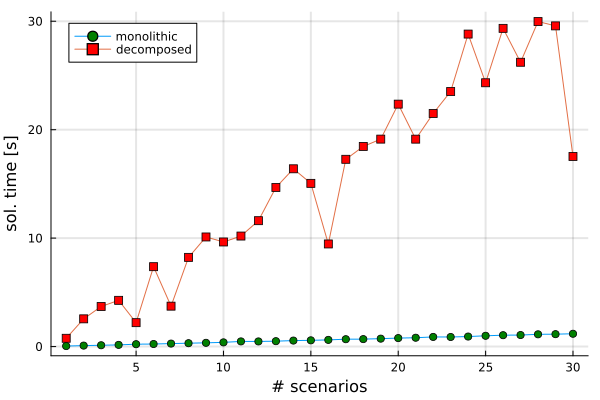

In [15]:
# solution time
p1 = plot(1:nScenMax,solTimeTraj_s[1,:],xlabel="# scenarios", ylabel="sol. time [s]",marker=:circle, markercolor = :green,label="monolithic")
p1 = plot!(1:nScenMax,solTimeTraj_s[2,:],marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p1)

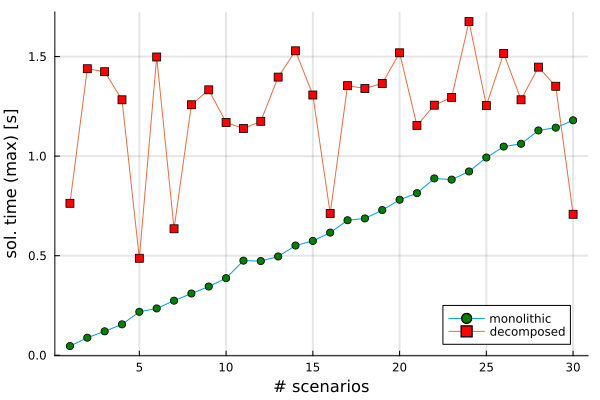

In [16]:
# solution time (parallel)
p2 = plot(1:nScenMax,solTimeTraj_s[1,:],xlabel="# scenarios", ylabel="sol. time (max) [s]",marker=:circle, markercolor = :green,label="monolithic")
p2 = plot!(1:nScenMax,solTimeMaxTraj_s,marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p2)

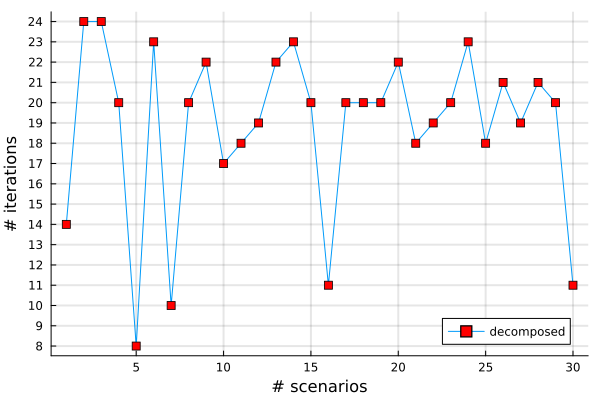

In [17]:
# number of iterations
function int_ticks(x; step=1) 
    imin = floor(Int, minimum(x))
    imax = ceil(Int, maximum(x))
    return range(imin, imax, step=step)
end

p3 = plot(1:nScenMax,iterTraj_s,xlabel="# scenarios", ylabel="# iterations",marker=:square, markercolor = :red,label="decomposed",yticks=int_ticks(iterTraj_s; step=1),gridlinewidth=2)
display(p3)

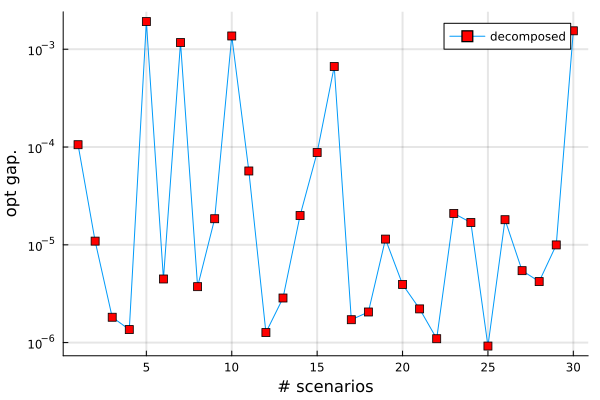

In [18]:
# number of iterations
p4 = plot(1:nScenMax,optGapTraj_s,yscale=:log10,xlabel="# scenarios", ylabel="opt gap.",marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p4)

# Checking the performance of the methods in terms of time vs. nReac

In [32]:
# testing the number of reactors in series (chosen arbitrarily as the same number of scenarios)
nReactMax = nScenMax

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_r = Matrix{Float64}(undef,2,nScenMax) 
# computed objective function
solObjTraj_r = Matrix{Float64}(undef,2,nScenMax) 
# --> only decomposed
# number of iterations
iterTraj_r = Vector{Float64}(undef,nScenMax) 
# optimality gap
optGapTraj_r = Vector{Float64}(undef,nScenMax) 

# number of reactors in parallel
nScenarios = 2
#equiprobable scenarios
pScenarios = 1.0/nScenarios

for rr = 1:nReactMax
    display("evaluating $(rr) reactors in parallel | option $(opti)")
        
    #number os reactors
    nReac = rr
    # Number of states
    nx = 2*nReac
        
    # Possible initial conditions (deviation form)
    xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReac,1])
    uInit_0 = 1.0 - u0
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)

    # solving decomposed problem    
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)
        
    # for plotting
    solTimeTraj_r[1,rr] = sol_m_Dict['t']
    solTimeTraj_r[2,rr] = sol_d_Dict['t']
    
    solObjTraj_r[1,rr] = sol_m_Dict['ϕ']
    solObjTraj_r[2,rr] = sol_d_Dict['ϕ']

    iterTraj_r[rr] = sol_d_Dict['i'] 
    optGapTraj_r[rr] = sol_d_Dict['g']

end


"evaluating 1 reactors in parallel | option 3"

" DB: opt gap = 1.0320443389947607"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9637009287584378"

">>>>>> iteration 2:O"

" DB: opt gap = 0.984397641723173"

">>>>>> iteration 3:O"

" DB: opt gap = 0.923749486287672"

">>>>>> iteration 4:O"

" DB: opt gap = 0.984300405005905"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8789015520512516"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9078742625165804"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8245933138847746"

">>>>>> iteration 8:O"

" DB: opt gap = 1.0143380784832878"

">>>>>> iteration 9:O"

" DB: opt gap = 0.014099970376185347"

">>>>>> iteration 10:O"

" DB: opt gap = 0.01409231800369356"

">>>>>> iteration 11:O"

" DB: opt gap = 0.014061646557025518"

">>>>>> iteration 12:O"

" DB: opt gap = 0.014051676345474067"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.014015763222294305"

">>>>>> iteration 15:O"

" DB: opt gap = 0.013945847665216584"

">>>>>> iteration 16:O"

" DB: opt gap = 0.013939115064442587"

">>>>>> iteration 17:O"

" DB: opt gap = 0.01317547354239571"

">>>>>> iteration 18:O"

" DB: opt gap = 0.01315903060472259"

">>>>>> iteration 19:O"

" DB: opt gap = 0.012967984833289118"

">>>>>> iteration 20:O"

" DB: opt gap = 0.012963791718237501"

">>>>>> iteration 21:O"

" DB: opt gap = 0.012921269879093839"

">>>>>> iteration 22:O"

" DB: opt gap = 0.01291708575175371"

">>>>>> iteration 23:O"

" DB: opt gap = 1.0904642044408822e-5"

"evaluating 2 reactors in parallel | option 3"

" DB: opt gap = 1.3143479588859137"

">>>>>> iteration 1:O"

" DB: opt gap = 1.0999127435470382"

">>>>>> iteration 2:O"

" DB: opt gap = 1.137441556028289"

">>>>>> iteration 3:O"

" DB: opt gap = 1.1496045650786093"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9681934611682144"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9356985006672854"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0098463909751967"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9120722617827896"

">>>>>> iteration 8:O"

" DB: opt gap = 0.015387456519240186"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01525537094966655"

">>>>>> iteration 10:O"

" DB: opt gap = 0.015216939962064583"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.015098241932976514"

">>>>>> iteration 13:O"

" DB: opt gap = 0.015059795442698256"

">>>>>> iteration 14:O"

" DB: opt gap = 0.01471204799500166"

">>>>>> iteration 15:O"

" DB: opt gap = 0.014683354498008535"

">>>>>> iteration 16:O"

" DB: opt gap = 3.041749180068331e-5"

"evaluating 3 reactors in parallel | option 3"

" DB: opt gap = 1.8762103660025657"

">>>>>> iteration 1:O"

" DB: opt gap = 1.5858167028057724"

">>>>>> iteration 2:O"

" DB: opt gap = 1.622345463173167"

">>>>>> iteration 3:O"

" DB: opt gap = 1.6072444660175758"

">>>>>> iteration 4:O"

" DB: opt gap = 1.27033375540968"

">>>>>> iteration 5:O"

" DB: opt gap = 1.2799248700690213"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0957156670711994"

">>>>>> iteration 7:O"

" DB: opt gap = 1.195740336917117"

">>>>>> iteration 8:O"

" DB: opt gap = 1.2042639080267232"

">>>>>> iteration 9:O"

" DB: opt gap = 0.5425062200803026"

">>>>>> iteration 10:O"

" DB: opt gap = 0.555993432816635"

">>>>>> iteration 11:O"

" DB: opt gap = 0.5542543802736103"

">>>>>> iteration 12:O"

" DB: opt gap = 0.5619999694664872"

">>>>>> iteration 13:O"

" DB: opt gap = 0.5704500261623524"

">>>>>> iteration 14:O"

" DB: opt gap = 0.012651957374133046"

">>>>>> iteration 15:O"

" DB: opt gap = 0.01266959784595369"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

" DB: opt gap = 0.012523889918195875"

">>>>>> iteration 18:O"

" DB: opt gap = 0.012504053157795807"

">>>>>> iteration 19:O"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 4 reactors in parallel | option 3"

" DB: opt gap = 2.5947627800410116"

">>>>>> iteration 1:O"

" DB: opt gap = 2.0276772093988615"

">>>>>> iteration 2:O"

" DB: opt gap = 1.805620522270938"

">>>>>> iteration 3:O"

" DB: opt gap = 1.5347054487765284"

">>>>>> iteration 4:O"

" DB: opt gap = 1.906364912278836"

">>>>>> iteration 5:O"

" DB: opt gap = 1.925070317487235"

">>>>>> iteration 6:O"

" DB: opt gap = 0.05202279569711003"

">>>>>> iteration 7:O"

" DB: opt gap = 0.05191165539781861"

">>>>>> iteration 8:O"

">>>>>> iteration 9:F"

" DB: opt gap = 0.05158966433754491"

">>>>>> iteration 10:O"

" DB: opt gap = 0.051476846393906865"

">>>>>> iteration 11:O"

" DB: opt gap = 0.04810411673302933"

">>>>>> iteration 12:O"

" DB: opt gap = 0.04768327736782922"

">>>>>> iteration 13:O"

" DB: opt gap = 0.04733101777327923"

">>>>>> iteration 14:O"

" DB: opt gap = 0.04638026028953495"

">>>>>> iteration 15:O"

" DB: opt gap = 0.00016832030552091116"

"evaluating 5 reactors in parallel | option 3"

" DB: opt gap = 3.5230799967656834"

">>>>>> iteration 1:O"

" DB: opt gap = 2.05647174907714"

">>>>>> iteration 2:O"

" DB: opt gap = 2.111802412092633"

">>>>>> iteration 3:O"

" DB: opt gap = 2.169998716153207"

">>>>>> iteration 4:O"

" DB: opt gap = 2.157726923679415"

">>>>>> iteration 5:O"

" DB: opt gap = 1.5657833040557396"

">>>>>> iteration 6:O"

" DB: opt gap = 1.3340662614713257"

">>>>>> iteration 7:O"

" DB: opt gap = 1.4932344766753012"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8342849029922543"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8935642881633888"

">>>>>> iteration 10:O"

" DB: opt gap = 0.912733660151826"

">>>>>> iteration 11:O"

" DB: opt gap = 0.9282084313248655"

">>>>>> iteration 12:O"

" DB: opt gap = 0.9481311840074703"

">>>>>> iteration 13:O"

" DB: opt gap = 1.0014213140017727"

">>>>>> iteration 14:O"

" DB: opt gap = 0.06257281077576805"

">>>>>> iteration 15:O"

" DB: opt gap = 0.000258506072641163"

"evaluating 6 reactors in parallel | option 3"

" DB: opt gap = 4.719848363337202"

">>>>>> iteration 1:O"

" DB: opt gap = 3.3492159154643906"

">>>>>> iteration 2:O"

" DB: opt gap = 2.408914424993896"

">>>>>> iteration 3:O"

" DB: opt gap = 1.861666069253927"

">>>>>> iteration 4:O"

" DB: opt gap = 2.4531129264429588"

">>>>>> iteration 5:O"

" DB: opt gap = 1.3107760620173292"

">>>>>> iteration 6:O"

" DB: opt gap = 1.4321790357042978"

">>>>>> iteration 7:O"

" DB: opt gap = 1.1461215011165462"

">>>>>> iteration 8:O"

" DB: opt gap = 1.9539430936164564"

">>>>>> iteration 9:O"

" DB: opt gap = 0.7505431798439067"

">>>>>> iteration 10:O"

" DB: opt gap = 0.7773533043879134"

">>>>>> iteration 11:O"

" DB: opt gap = 0.06798408001349297"

">>>>>> iteration 12:O"

" DB: opt gap = 0.06619882764834721"

">>>>>> iteration 13:O"

" DB: opt gap = 0.06597357843733946"

">>>>>> iteration 14:O"

" DB: opt gap = 0.0013915320087986795"

"evaluating 7 reactors in parallel | option 3"

" DB: opt gap = 6.321651918713679"

">>>>>> iteration 1:O"

" DB: opt gap = 4.070062737118368"

">>>>>> iteration 2:O"

" DB: opt gap = 4.097831619271456"

">>>>>> iteration 3:O"

" DB: opt gap = 4.084362488084401"

">>>>>> iteration 4:O"

" DB: opt gap = 2.2499791450052027"

">>>>>> iteration 5:O"

" DB: opt gap = 2.6719459287013"

">>>>>> iteration 6:O"

" DB: opt gap = 3.1499740308595383"

">>>>>> iteration 7:O"

" DB: opt gap = 1.8514679188993841"

">>>>>> iteration 8:O"

" DB: opt gap = 2.7871258469366382"

">>>>>> iteration 9:O"

" DB: opt gap = 2.309905589877054"

">>>>>> iteration 10:O"

" DB: opt gap = 0.14498683784509628"

">>>>>> iteration 11:O"

" DB: opt gap = 0.14077446514479483"

">>>>>> iteration 12:O"

" DB: opt gap = 0.12099009749067208"

">>>>>> iteration 13:O"

" DB: opt gap = 0.12553445589186116"

">>>>>> iteration 14:O"

" DB: opt gap = 0.11548550633358945"

">>>>>> iteration 15:O"

" DB: opt gap = 0.11238117153126705"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0018122808253066387"

"evaluating 8 reactors in parallel | option 3"

" DB: opt gap = 8.689076585917498"

">>>>>> iteration 1:O"

" DB: opt gap = 3.0713220526630614"

">>>>>> iteration 2:O"

" DB: opt gap = 2.8832905140203673"

">>>>>> iteration 3:O"

" DB: opt gap = 3.0835663491264294"

">>>>>> iteration 4:O"

" DB: opt gap = 2.7059666391493216"

">>>>>> iteration 5:O"

" DB: opt gap = 2.064576289930702"

">>>>>> iteration 6:O"

" DB: opt gap = 1.664509363956768"

">>>>>> iteration 7:O"

" DB: opt gap = 2.3555790302350395"

">>>>>> iteration 8:O"

" DB: opt gap = 1.3546602410121"

">>>>>> iteration 9:O"

" DB: opt gap = 2.00601852212738"

">>>>>> iteration 10:O"

" DB: opt gap = 2.143570532560505"

">>>>>> iteration 11:O"

" DB: opt gap = 0.16722047212116462"

">>>>>> iteration 12:O"

" DB: opt gap = 0.1659250766997892"

">>>>>> iteration 13:O"

" DB: opt gap = 0.15895824297047242"

">>>>>> iteration 14:O"

" DB: opt gap = 0.15779093641215566"

">>>>>> iteration 15:O"

" DB: opt gap = 0.00015375162485612676"

"evaluating 9 reactors in parallel | option 3"

" DB: opt gap = 12.679508989450422"

">>>>>> iteration 1:O"

" DB: opt gap = 3.4552506043166344"

">>>>>> iteration 2:O"

" DB: opt gap = 3.313891386061852"

">>>>>> iteration 3:O"

" DB: opt gap = 4.209644172600173"

">>>>>> iteration 4:O"

" DB: opt gap = 2.2680123345782603"

">>>>>> iteration 5:O"

" DB: opt gap = 2.418413428899634"

">>>>>> iteration 6:O"

" DB: opt gap = 3.0511608007850044"

">>>>>> iteration 7:O"

" DB: opt gap = 1.50421850639149"

">>>>>> iteration 8:O"

" DB: opt gap = 1.6254421511970483"

">>>>>> iteration 9:O"

" DB: opt gap = 0.12279068395632921"

">>>>>> iteration 10:O"

" DB: opt gap = 0.10891326281654566"

">>>>>> iteration 11:O"

" DB: opt gap = 0.10630481830890895"

">>>>>> iteration 12:O"

" DB: opt gap = 0.027726878760234972"

">>>>>> iteration 13:O"

" DB: opt gap = 0.027763898227915456"

">>>>>> iteration 14:O"

" DB: opt gap = 0.027864700306480757"

">>>>>> iteration 15:O"

" DB: opt gap = 0.027980659934352586"

">>>>>> iteration 16:O"

" DB: opt gap = 0.005322421767839856"

">>>>>> iteration 17:O"

" DB: opt gap = 0.0054207101485913055"

">>>>>> iteration 18:O"

" DB: opt gap = 0.0053615181919052434"

">>>>>> iteration 19:O"

" DB: opt gap = 0.005427698179265776"

">>>>>> iteration 20:O"

" DB: opt gap = 0.005487313006773852"

">>>>>> iteration 21:O"

" DB: opt gap = 0.0016123559507380675"

"evaluating 10 reactors in parallel | option 3"

" DB: opt gap = 21.033602797836558"

">>>>>> iteration 1:O"

" DB: opt gap = 3.8566631167078476"

">>>>>> iteration 2:O"

" DB: opt gap = 3.6774612459669522"

">>>>>> iteration 3:O"

" DB: opt gap = 4.8577370572343925"

">>>>>> iteration 4:O"

" DB: opt gap = 2.38743801430507"

">>>>>> iteration 5:O"

" DB: opt gap = 2.6467049894167602"

">>>>>> iteration 6:O"

" DB: opt gap = 3.5091359087063156"

">>>>>> iteration 7:O"

" DB: opt gap = 1.7212711637068698"

">>>>>> iteration 8:O"

" DB: opt gap = 0.19175949835871056"

">>>>>> iteration 9:O"

" DB: opt gap = 0.15660617460468026"

">>>>>> iteration 10:O"

" DB: opt gap = 0.15519259132985413"

">>>>>> iteration 11:O"

" DB: opt gap = 0.14162510257193198"

">>>>>> iteration 12:O"

" DB: opt gap = 0.12544509914567173"

">>>>>> iteration 13:O"

" DB: opt gap = 0.1211292741570753"

">>>>>> iteration 14:O"

" DB: opt gap = 0.12227158005444864"

">>>>>> iteration 15:O"

" DB: opt gap = 0.10813293996054923"

">>>>>> iteration 16:O"

" DB: opt gap = 0.02321688817352986"

">>>>>> iteration 17:O"

" DB: opt gap = 0.02306247266464259"

">>>>>> iteration 18:O"

" DB: opt gap = 0.023195402170533955"

">>>>>> iteration 19:O"

" DB: opt gap = 0.023125911517784502"

">>>>>> iteration 20:O"

" DB: opt gap = 0.02302627237826331"

">>>>>> iteration 21:O"

" DB: opt gap = 0.005718127724565632"

">>>>>> iteration 22:O"

" DB: opt gap = 0.001629369946004406"

"evaluating 11 reactors in parallel | option 3"

" DB: opt gap = 50.94968944191028"

">>>>>> iteration 1:O"

" DB: opt gap = 4.327991555471362"

">>>>>> iteration 2:O"

" DB: opt gap = 4.12015809544221"

">>>>>> iteration 3:O"

" DB: opt gap = 4.347173525122483"

">>>>>> iteration 4:O"

" DB: opt gap = 2.6136170483382917"

">>>>>> iteration 5:O"

" DB: opt gap = 2.1244407685220557"

">>>>>> iteration 6:O"

" DB: opt gap = 2.028256226060182"

">>>>>> iteration 7:O"

" DB: opt gap = 1.9031612298863807"

">>>>>> iteration 8:O"

" DB: opt gap = 2.1297032402226677"

">>>>>> iteration 9:O"

" DB: opt gap = 1.3630660667170105"

">>>>>> iteration 10:O"

" DB: opt gap = 1.3364282235621807"

">>>>>> iteration 11:O"

" DB: opt gap = 0.1618780985014567"

">>>>>> iteration 12:O"

" DB: opt gap = 0.07446088344066536"

">>>>>> iteration 13:O"

" DB: opt gap = 0.045172739439005356"

">>>>>> iteration 14:O"

" DB: opt gap = 0.043776355298526526"

">>>>>> iteration 15:O"

" DB: opt gap = 0.07571639035688861"

">>>>>> iteration 16:O"

" DB: opt gap = 0.07019203001310526"

">>>>>> iteration 17:O"

" DB: opt gap = 0.04178480500777802"

">>>>>> iteration 18:O"

" DB: opt gap = 0.038107493029320025"

">>>>>> iteration 19:O"

" DB: opt gap = 0.012654555472003072"

">>>>>> iteration 20:O"

" DB: opt gap = 0.012650003259242206"

">>>>>> iteration 21:O"

" DB: opt gap = 0.010691844188756969"

">>>>>> iteration 22:O"

" DB: opt gap = 0.010683340289113406"

">>>>>> iteration 23:O"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 12 reactors in parallel | option 3"

" DB: opt gap = 167.42798636281714"

">>>>>> iteration 1:O"

" DB: opt gap = 4.9377304876569665"

">>>>>> iteration 2:O"

" DB: opt gap = 4.662728792929486"

">>>>>> iteration 3:O"

" DB: opt gap = 5.176947466343229"

">>>>>> iteration 4:O"

" DB: opt gap = 6.007060690731719"

">>>>>> iteration 5:O"

" DB: opt gap = 0.7945053704212671"

">>>>>> iteration 6:O"

" DB: opt gap = 0.7519435647958682"

">>>>>> iteration 7:O"

" DB: opt gap = 0.5191923765241732"

">>>>>> iteration 8:O"

" DB: opt gap = 0.5103097378621222"

">>>>>> iteration 9:O"

" DB: opt gap = 0.4156829861352011"

">>>>>> iteration 10:O"

" DB: opt gap = 0.33977941075721074"

">>>>>> iteration 11:O"

" DB: opt gap = 0.33765501749369803"

">>>>>> iteration 12:O"

" DB: opt gap = 0.09465434669579507"

">>>>>> iteration 13:O"

" DB: opt gap = 0.08712501097998071"

">>>>>> iteration 14:O"

" DB: opt gap = 0.09655536681593288"

">>>>>> iteration 15:O"

" DB: opt gap = 0.049351119605135996"

">>>>>> iteration 16:O"

" DB: opt gap = 0.018510079605649692"

">>>>>> iteration 17:O"

" DB: opt gap = 0.018512815414903138"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

" DB: opt gap = 0.018496607542120992"

">>>>>> iteration 20:O"

" DB: opt gap = 0.018497926353751103"

">>>>>> iteration 21:O"

" DB: opt gap = 0.01606065571235761"

">>>>>> iteration 22:O"

" DB: opt gap = 0.005781283143733291"

">>>>>> iteration 23:O"

" DB: opt gap = 0.005774163926608487"

">>>>>> iteration 24:O"

" DB: opt gap = 0.005722558094877165"

">>>>>> iteration 25:O"

" DB: opt gap = 0.0057150117849733935"

">>>>>> iteration 26:O"

" DB: opt gap = 0.0013426180988283648"

"evaluating 13 reactors in parallel | option 3"

" DB: opt gap = 33.520349196365906"

">>>>>> iteration 1:O"

" DB: opt gap = 10.678578114516121"

">>>>>> iteration 2:O"

" DB: opt gap = 5.543237044912135"

">>>>>> iteration 3:O"

" DB: opt gap = 3.977124989530846"

">>>>>> iteration 4:O"

" DB: opt gap = 9.910957178351884"

">>>>>> iteration 5:O"

" DB: opt gap = 4.3117195747032175"

">>>>>> iteration 6:O"

" DB: opt gap = 3.842532304255628"

">>>>>> iteration 7:O"

" DB: opt gap = 7.324942035165697"

">>>>>> iteration 8:O"

" DB: opt gap = 0.754534509612223"

">>>>>> iteration 9:O"

" DB: opt gap = 0.6927661633353891"

">>>>>> iteration 10:O"

" DB: opt gap = 0.5836503324099263"

">>>>>> iteration 11:O"

" DB: opt gap = 0.4504031423277888"

">>>>>> iteration 12:O"

" DB: opt gap = 0.44576048450581496"

">>>>>> iteration 13:O"

" DB: opt gap = 0.40852579189415905"

">>>>>> iteration 14:O"

" DB: opt gap = 0.40668142257551587"

">>>>>> iteration 15:O"

" DB: opt gap = 0.08585618887322922"

">>>>>> iteration 16:O"

" DB: opt gap = 0.08660462900061991"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 0.08740826258391655"

">>>>>> iteration 19:O"

" DB: opt gap = 0.08924517658368278"

">>>>>> iteration 20:O"

" DB: opt gap = 0.05841507029241446"

">>>>>> iteration 21:O"

" DB: opt gap = 0.022422398939966278"

">>>>>> iteration 22:O"

" DB: opt gap = 0.01812915682608644"

">>>>>> iteration 23:O"

" DB: opt gap = 0.018141618183637635"

">>>>>> iteration 24:O"

" DB: opt gap = 0.018128460791002856"

">>>>>> iteration 25:O"

" DB: opt gap = 0.018160555313169405"

">>>>>> iteration 26:O"

" DB: opt gap = 0.006295642064746387"

">>>>>> iteration 27:O"

" DB: opt gap = 0.0016146985422732757"

"evaluating 14 reactors in parallel | option 3"

" DB: opt gap = 19.113511726225003"

">>>>>> iteration 1:O"

" DB: opt gap = 6.721783657100218"

">>>>>> iteration 2:O"

" DB: opt gap = 5.592340798291642"

">>>>>> iteration 3:O"

" DB: opt gap = 9.526363968821045"

">>>>>> iteration 4:O"

" DB: opt gap = 4.35471486624085"

">>>>>> iteration 5:O"

" DB: opt gap = 2.6162001882669705"

">>>>>> iteration 6:O"

" DB: opt gap = 2.9425105532503912"

">>>>>> iteration 7:O"

" DB: opt gap = 3.7295512556705352"

">>>>>> iteration 8:O"

" DB: opt gap = 2.097446215737616"

">>>>>> iteration 9:O"

" DB: opt gap = 1.8172474553594977"

">>>>>> iteration 10:O"

" DB: opt gap = 0.2819401537856658"

">>>>>> iteration 11:O"

" DB: opt gap = 0.20331793695911893"

">>>>>> iteration 12:O"

" DB: opt gap = 0.28465311865388165"

">>>>>> iteration 13:O"

" DB: opt gap = 0.07695747887777836"

">>>>>> iteration 14:O"

" DB: opt gap = 0.07650223284583982"

">>>>>> iteration 15:O"

" DB: opt gap = 0.11752071948103296"

">>>>>> iteration 16:O"

" DB: opt gap = 0.06168508040959235"

">>>>>> iteration 17:O"

" DB: opt gap = 0.011801533205630876"

">>>>>> iteration 18:O"

" DB: opt gap = 0.011806916987839925"

">>>>>> iteration 19:O"

" DB: opt gap = 0.01180765731421486"

">>>>>> iteration 20:O"

" DB: opt gap = 0.011821674918320266"

">>>>>> iteration 21:O"

" DB: opt gap = 0.004212452910219565"

">>>>>> iteration 22:O"

" DB: opt gap = 0.004170027453764765"

">>>>>> iteration 23:O"

" DB: opt gap = 0.003214459328840441"

">>>>>> iteration 24:O"

" DB: opt gap = 0.0012113961445191352"

"evaluating 15 reactors in parallel | option 3"

" DB: opt gap = 13.566463099541659"

">>>>>> iteration 1:O"

" DB: opt gap = 20.54106910938446"

">>>>>> iteration 2:O"

" DB: opt gap = 18.21981528726547"

">>>>>> iteration 3:O"

" DB: opt gap = 25.51727845727672"

">>>>>> iteration 4:O"

" DB: opt gap = 4.861439287328523"

">>>>>> iteration 5:O"

" DB: opt gap = 5.602273925924486"

">>>>>> iteration 6:O"

" DB: opt gap = 8.862018809843779"

">>>>>> iteration 7:O"

" DB: opt gap = 3.4559413040485314"

">>>>>> iteration 8:O"

" DB: opt gap = 2.7070755508223376"

">>>>>> iteration 9:O"

" DB: opt gap = 0.4995770765697374"

">>>>>> iteration 10:O"

" DB: opt gap = 0.20117399063031136"

">>>>>> iteration 11:O"

" DB: opt gap = 0.2761748273133071"

">>>>>> iteration 12:O"

" DB: opt gap = 0.3638685418529176"

">>>>>> iteration 13:O"

" DB: opt gap = 0.2031616459473868"

">>>>>> iteration 14:O"

" DB: opt gap = 0.22544408480902536"

">>>>>> iteration 15:O"

" DB: opt gap = 0.2510059276151395"

">>>>>> iteration 16:O"

" DB: opt gap = 0.2876480217533661"

">>>>>> iteration 17:O"

" DB: opt gap = 0.24446414296731342"

">>>>>> iteration 18:O"

" DB: opt gap = 0.07534836318084787"

">>>>>> iteration 19:O"

" DB: opt gap = 0.0755825538844406"

">>>>>> iteration 20:O"

" DB: opt gap = 0.01902451494993836"

">>>>>> iteration 21:O"

" DB: opt gap = 0.019052721877835938"

">>>>>> iteration 22:O"

">>>>>> iteration 23:F"

" DB: opt gap = 0.02134741000201365"

">>>>>> iteration 24:O"

" DB: opt gap = 0.010873154839429114"

">>>>>> iteration 25:O"

" DB: opt gap = 0.021256273510113083"

">>>>>> iteration 26:O"

" DB: opt gap = 0.020824718241426954"

">>>>>> iteration 27:O"

" DB: opt gap = 0.021130393846044728"

">>>>>> iteration 28:O"

" DB: opt gap = 0.00848171974598206"

">>>>>> iteration 29:O"

" DB: opt gap = 0.007348913920097942"

">>>>>> iteration 30:O"

" DB: opt gap = 0.0073718243430180835"

">>>>>> iteration 31:O"

" DB: opt gap = 0.007251199425186471"

">>>>>> iteration 32:O"

" DB: opt gap = 0.007370788922547777"

">>>>>> iteration 33:O"

" DB: opt gap = 0.007168154618855651"

">>>>>> iteration 34:O"

" DB: opt gap = 0.007377243700471131"

">>>>>> iteration 35:O"

" DB: opt gap = 0.0028560008551217746"

">>>>>> iteration 36:O"

" DB: opt gap = 0.0012428211715804316"

"evaluating 16 reactors in parallel | option 3"

" DB: opt gap = 10.61063827947524"

">>>>>> iteration 1:O"

" DB: opt gap = 9.65755265079562"

">>>>>> iteration 2:O"

" DB: opt gap = 9.101323628369068"

">>>>>> iteration 3:O"

" DB: opt gap = 22.384627063622"

">>>>>> iteration 4:O"

" DB: opt gap = 6.252748589166151"

">>>>>> iteration 5:O"

" DB: opt gap = 4.41167435054361"

">>>>>> iteration 6:O"

" DB: opt gap = 3.3134424688619717"

">>>>>> iteration 7:O"

" DB: opt gap = 5.846579752469291"

">>>>>> iteration 8:O"

" DB: opt gap = 2.461992335613647"

">>>>>> iteration 9:O"

" DB: opt gap = 0.42605137959860745"

">>>>>> iteration 10:O"

" DB: opt gap = 0.3396376146125089"

">>>>>> iteration 11:O"

" DB: opt gap = 0.2821994129120717"

">>>>>> iteration 12:O"

" DB: opt gap = 0.4262313364965779"

">>>>>> iteration 13:O"

" DB: opt gap = 0.351225481969838"

">>>>>> iteration 14:O"

" DB: opt gap = 0.34811467391588724"

">>>>>> iteration 15:O"

" DB: opt gap = 0.09559437443932466"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0951694130840849"

">>>>>> iteration 17:O"

" DB: opt gap = 0.0193609191917975"

">>>>>> iteration 18:O"

" DB: opt gap = 0.019226200440331763"

">>>>>> iteration 19:O"

" DB: opt gap = 0.019368459930770434"

">>>>>> iteration 20:O"

">>>>>> iteration 21:F"

" DB: opt gap = 0.019289747480863453"

">>>>>> iteration 22:O"

" DB: opt gap = 0.017342927226529577"

">>>>>> iteration 23:O"

" DB: opt gap = 0.016909213017442977"

">>>>>> iteration 24:O"

" DB: opt gap = 0.017019918320324075"

">>>>>> iteration 25:O"

" DB: opt gap = 0.0157866503540949"

">>>>>> iteration 26:O"

" DB: opt gap = 0.018544475146541686"

">>>>>> iteration 27:O"

" DB: opt gap = 0.006505597913888858"

">>>>>> iteration 28:O"

" DB: opt gap = 0.005827531305551764"

">>>>>> iteration 29:O"

" DB: opt gap = 0.005750765401691542"

">>>>>> iteration 30:O"

" DB: opt gap = 0.005831532763371721"

">>>>>> iteration 31:O"

" DB: opt gap = 0.005739386540570433"

">>>>>> iteration 32:O"

" DB: opt gap = 0.0058162068376103595"

">>>>>> iteration 33:O"

" DB: opt gap = 0.005819992643587212"

">>>>>> iteration 34:O"

" DB: opt gap = 0.001605514386985336"

"evaluating 17 reactors in parallel | option 3"

" DB: opt gap = 8.773727420957687"

">>>>>> iteration 1:O"

" DB: opt gap = 133.77153969512102"

">>>>>> iteration 2:O"

" DB: opt gap = 120.01920403166969"

">>>>>> iteration 3:O"

" DB: opt gap = 39.06553927586616"

">>>>>> iteration 4:O"

" DB: opt gap = 5.892540117402428"

">>>>>> iteration 5:O"

" DB: opt gap = 8.136178338177189"

">>>>>> iteration 6:O"

" DB: opt gap = 5.45262132326279"

">>>>>> iteration 7:O"

" DB: opt gap = 5.006381772063332"

">>>>>> iteration 8:O"

" DB: opt gap = 34.712610075700596"

">>>>>> iteration 9:O"

" DB: opt gap = 1.4475235107529858"

">>>>>> iteration 10:O"

" DB: opt gap = 0.8593574187942736"

">>>>>> iteration 11:O"

" DB: opt gap = 0.8323714668228018"

">>>>>> iteration 12:O"

" DB: opt gap = 0.15698514620633208"

">>>>>> iteration 13:O"

" DB: opt gap = 0.15390297188976507"

">>>>>> iteration 14:O"

" DB: opt gap = 0.15615765564070722"

">>>>>> iteration 15:O"

" DB: opt gap = 0.15316505412044662"

">>>>>> iteration 16:O"

" DB: opt gap = 0.057695187034974074"

">>>>>> iteration 17:O"

" DB: opt gap = 0.05822396878588268"

">>>>>> iteration 18:O"

" DB: opt gap = 0.057599766572440536"

">>>>>> iteration 19:O"

" DB: opt gap = 0.021999257617530434"

">>>>>> iteration 20:O"

" DB: opt gap = 0.020862873687192515"

">>>>>> iteration 21:O"

" DB: opt gap = 0.043914190830087206"

">>>>>> iteration 22:O"

" DB: opt gap = 0.019255933778235437"

">>>>>> iteration 23:O"

" DB: opt gap = 0.015940767137072823"

">>>>>> iteration 24:O"

" DB: opt gap = 0.015859302501294355"

">>>>>> iteration 25:O"

" DB: opt gap = 0.0036590414551021587"

">>>>>> iteration 26:O"

" DB: opt gap = 0.0036607722633983037"

">>>>>> iteration 27:O"

">>>>>> iteration 28:F"

" DB: opt gap = 0.0036598697225571734"

">>>>>> iteration 29:O"

" DB: opt gap = 0.0036617453639407865"

">>>>>> iteration 30:O"

" DB: opt gap = 0.0023140465589366354"

">>>>>> iteration 31:O"

" DB: opt gap = 0.0009156537894180046"

"evaluating 18 reactors in parallel | option 3"

" DB: opt gap = 7.525805889388412"

">>>>>> iteration 1:O"

" DB: opt gap = 16.671942049278666"

">>>>>> iteration 2:O"

" DB: opt gap = 16.111441919615956"

">>>>>> iteration 3:O"

" DB: opt gap = 428.8709200894554"

">>>>>> iteration 4:O"

" DB: opt gap = 6.61222885917498"

">>>>>> iteration 5:O"

" DB: opt gap = 9.045434716213329"

">>>>>> iteration 6:O"

" DB: opt gap = 18.231819879016722"

">>>>>> iteration 7:O"

" DB: opt gap = 2.071115641821679"

">>>>>> iteration 8:O"

" DB: opt gap = 1.6306080903452205"

">>>>>> iteration 9:O"

" DB: opt gap = 1.189238392696821"

">>>>>> iteration 10:O"

" DB: opt gap = 1.233455406789289"

">>>>>> iteration 11:O"

" DB: opt gap = 1.064773072431759"

">>>>>> iteration 12:O"

" DB: opt gap = 0.9536344964083967"

">>>>>> iteration 13:O"

" DB: opt gap = 0.3018858886918435"

">>>>>> iteration 14:O"

" DB: opt gap = 0.2909370271989469"

">>>>>> iteration 15:O"

" DB: opt gap = 0.29865509875194535"

">>>>>> iteration 16:O"

" DB: opt gap = 0.29587705450726887"

">>>>>> iteration 17:O"

" DB: opt gap = 0.09548389874865718"

">>>>>> iteration 18:O"

" DB: opt gap = 0.09875071751795916"

">>>>>> iteration 19:O"

" DB: opt gap = 0.09645869772893707"

">>>>>> iteration 20:O"

" DB: opt gap = 0.10003994807976832"

">>>>>> iteration 21:O"

" DB: opt gap = 0.05052247531605776"

">>>>>> iteration 22:O"

" DB: opt gap = 0.04847592374892044"

">>>>>> iteration 23:O"

" DB: opt gap = 0.05096757182181633"

">>>>>> iteration 24:O"

" DB: opt gap = 0.018769005670370036"

">>>>>> iteration 25:O"

" DB: opt gap = 0.009325607231844082"

">>>>>> iteration 26:O"

" DB: opt gap = 0.009271587616827743"

">>>>>> iteration 27:O"

" DB: opt gap = 0.010499445726756922"

">>>>>> iteration 28:O"

" DB: opt gap = 0.005811120658940269"

">>>>>> iteration 29:O"

" DB: opt gap = 0.005802913962074345"

">>>>>> iteration 30:O"

" DB: opt gap = 0.005789291107633414"

">>>>>> iteration 31:O"

" DB: opt gap = 0.0023112087797956937"

">>>>>> iteration 32:O"

" DB: opt gap = 0.000702316937670791"

"evaluating 19 reactors in parallel | option 3"

" DB: opt gap = 6.623157316153054"

">>>>>> iteration 1:O"

" DB: opt gap = 29.16703542112359"

">>>>>> iteration 2:O"

" DB: opt gap = 25.610118096531053"

">>>>>> iteration 3:O"

" DB: opt gap = 19.729161958629042"

">>>>>> iteration 4:O"

" DB: opt gap = 18.147259713656528"

">>>>>> iteration 5:O"

" DB: opt gap = 19.824153428221763"

">>>>>> iteration 6:O"

" DB: opt gap = 22.356536007116233"

">>>>>> iteration 7:O"

" DB: opt gap = 1.687394116764601"

">>>>>> iteration 8:O"

" DB: opt gap = 1.3517211115600314"

">>>>>> iteration 9:O"

" DB: opt gap = 1.4731221150539824"

">>>>>> iteration 10:O"

" DB: opt gap = 1.1905690238406994"

">>>>>> iteration 11:O"

" DB: opt gap = 0.1751749046403261"

">>>>>> iteration 12:O"

" DB: opt gap = 0.17606953590660743"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

">>>>>> iteration 15:F"

">>>>>> iteration 16:F"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 20 reactors in parallel | option 3"

" DB: opt gap = 5.939856193433336"

">>>>>> iteration 1:O"

" DB: opt gap = 112.3029556838703"

">>>>>> iteration 2:O"

" DB: opt gap = 70.97059392314117"

">>>>>> iteration 3:O"

" DB: opt gap = 63.944363803147176"

">>>>>> iteration 4:O"

" DB: opt gap = 17.16537759372708"

">>>>>> iteration 5:O"

" DB: opt gap = 22.72115918353565"

">>>>>> iteration 6:O"

" DB: opt gap = 16.655904511745472"

">>>>>> iteration 7:O"

" DB: opt gap = 12.118848796044233"

">>>>>> iteration 8:O"

" DB: opt gap = 4.873968718703445"

">>>>>> iteration 9:O"

" DB: opt gap = 1.8200477173170444"

">>>>>> iteration 10:O"

" DB: opt gap = 1.6914277995802283"

">>>>>> iteration 11:O"

" DB: opt gap = 0.2259921408719386"

">>>>>> iteration 12:O"

" DB: opt gap = 0.2290780317254243"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.22641238894327922"

">>>>>> iteration 15:O"

" DB: opt gap = 0.22950177586441964"

">>>>>> iteration 16:O"

" DB: opt gap = 0.04398150271313844"

">>>>>> iteration 17:O"

" DB: opt gap = 0.045161520339678365"

">>>>>> iteration 18:O"

" DB: opt gap = 0.044581864939568165"

">>>>>> iteration 19:O"

" DB: opt gap = 0.011495932903528211"

">>>>>> iteration 20:O"

" DB: opt gap = 0.01158723460711545"

">>>>>> iteration 21:O"

" DB: opt gap = 0.011603030682869189"

">>>>>> iteration 22:O"

" DB: opt gap = 0.002869591420296375"

">>>>>> iteration 23:O"

" DB: opt gap = 0.0028654572654885245"

">>>>>> iteration 24:O"

" DB: opt gap = 0.0003620268003948061"

"evaluating 21 reactors in parallel | option 3"

" DB: opt gap = 5.404478123348038"

">>>>>> iteration 1:O"

" DB: opt gap = 14.378438910657229"

">>>>>> iteration 2:O"

" DB: opt gap = 8.639544950500449"

">>>>>> iteration 3:O"

" DB: opt gap = 63.316549672959816"

">>>>>> iteration 4:O"

" DB: opt gap = 162.97713872924535"

">>>>>> iteration 5:O"

" DB: opt gap = 54.35168368043824"

">>>>>> iteration 6:O"

" DB: opt gap = 26.635227562032835"

">>>>>> iteration 7:O"

" DB: opt gap = 5.254750251070877"

">>>>>> iteration 8:O"

" DB: opt gap = 6.08481024326426"

">>>>>> iteration 9:O"

" DB: opt gap = 7.078731209774818"

">>>>>> iteration 10:O"

" DB: opt gap = 1.9591903100988437"

">>>>>> iteration 11:O"

" DB: opt gap = 1.6524256043024057"

">>>>>> iteration 12:O"

" DB: opt gap = 2.1947698268919202"

">>>>>> iteration 13:O"

" DB: opt gap = 1.5904588934014772"

">>>>>> iteration 14:O"

" DB: opt gap = 1.6415663719050753"

">>>>>> iteration 15:O"

" DB: opt gap = 0.2606562396693114"

">>>>>> iteration 16:O"

" DB: opt gap = 0.2649180721309376"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 0.2678239232024335"

">>>>>> iteration 19:O"

" DB: opt gap = 0.27249184683172206"

">>>>>> iteration 20:O"

" DB: opt gap = 0.2384512170064413"

">>>>>> iteration 21:O"

" DB: opt gap = 0.05054209085059117"

">>>>>> iteration 22:O"

" DB: opt gap = 0.014404858953122572"

">>>>>> iteration 23:O"

" DB: opt gap = 0.01429129743341458"

">>>>>> iteration 24:O"

" DB: opt gap = 0.014418964636608519"

">>>>>> iteration 25:O"

" DB: opt gap = 0.014383024685643123"

">>>>>> iteration 26:O"

" DB: opt gap = 0.0020893599901180906"

">>>>>> iteration 27:O"

" DB: opt gap = 0.002090163949272659"

">>>>>> iteration 28:O"

" DB: opt gap = 0.0020851933539393786"

">>>>>> iteration 29:O"

" DB: opt gap = 0.0005737509206099361"

"evaluating 22 reactors in parallel | option 3"

" DB: opt gap = 4.973570096919342"

">>>>>> iteration 1:O"

" DB: opt gap = 8.39669265108929"

">>>>>> iteration 2:O"

" DB: opt gap = 34.31537450889898"

">>>>>> iteration 3:O"

" DB: opt gap = 90.72554381354756"

">>>>>> iteration 4:O"

" DB: opt gap = 11.128581641867418"

">>>>>> iteration 5:O"

" DB: opt gap = 14.394239097784208"

">>>>>> iteration 6:O"

" DB: opt gap = 9.887253845384029"

">>>>>> iteration 7:O"

" DB: opt gap = 16.900415880529277"

">>>>>> iteration 8:O"

" DB: opt gap = 13.448498087714848"

">>>>>> iteration 9:O"

" DB: opt gap = 200.93172779577787"

">>>>>> iteration 10:O"

" DB: opt gap = 2.5551867989067776"

">>>>>> iteration 11:O"

" DB: opt gap = 11.573417340368358"

">>>>>> iteration 12:O"

" DB: opt gap = 2.135828373726433"

">>>>>> iteration 13:O"

" DB: opt gap = 3.7327080379595112"

">>>>>> iteration 14:O"

" DB: opt gap = 0.5255323315941706"

">>>>>> iteration 15:O"

" DB: opt gap = 0.5091938674604819"

">>>>>> iteration 16:O"

" DB: opt gap = 0.2778907074683473"

">>>>>> iteration 17:O"

" DB: opt gap = 0.052874472185174055"

">>>>>> iteration 18:O"

" DB: opt gap = 0.05095547671073156"

">>>>>> iteration 19:O"

" DB: opt gap = 0.05150958454031875"

">>>>>> iteration 20:O"

" DB: opt gap = 0.06851377428360973"

">>>>>> iteration 21:O"

" DB: opt gap = 0.03499063123430686"

">>>>>> iteration 22:O"

" DB: opt gap = 0.03448985605905815"

">>>>>> iteration 23:O"

" DB: opt gap = 0.016864359587875973"

">>>>>> iteration 24:O"

" DB: opt gap = 0.016874471651271324"

">>>>>> iteration 25:O"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 23 reactors in parallel | option 3"

" DB: opt gap = 4.619113278610564"

">>>>>> iteration 1:O"

" DB: opt gap = 16.996799841305677"

">>>>>> iteration 2:O"

" DB: opt gap = 13.35675371047801"

">>>>>> iteration 3:O"

" DB: opt gap = 11.49607639634348"

">>>>>> iteration 4:O"

" DB: opt gap = 71.4276450660736"

">>>>>> iteration 5:O"

" DB: opt gap = 11.151938044008032"

">>>>>> iteration 6:O"

" DB: opt gap = 7.6010472454952644"

">>>>>> iteration 7:O"

" DB: opt gap = 16.676902432751813"

">>>>>> iteration 8:O"

" DB: opt gap = 2.651273101733939"

">>>>>> iteration 9:O"

" DB: opt gap = 1.694544089971274"

">>>>>> iteration 10:O"

" DB: opt gap = 2.2558736582599064"

">>>>>> iteration 11:O"

" DB: opt gap = 0.979568764242514"

">>>>>> iteration 12:O"

" DB: opt gap = 1.443180919977309"

">>>>>> iteration 13:O"

" DB: opt gap = 2.9306516153617386"

">>>>>> iteration 14:O"

" DB: opt gap = 0.5833155139569697"

">>>>>> iteration 15:O"

" DB: opt gap = 0.5458630004705947"

">>>>>> iteration 16:O"

" DB: opt gap = 1.0077805451126642"

">>>>>> iteration 17:O"

" DB: opt gap = 0.19097317112013357"

">>>>>> iteration 18:O"

" DB: opt gap = 0.37622668623947136"

">>>>>> iteration 19:O"

" DB: opt gap = 0.37705610722460187"

">>>>>> iteration 20:O"

" DB: opt gap = 0.1444439401766474"

">>>>>> iteration 21:O"

" DB: opt gap = 0.14464628721814352"

">>>>>> iteration 22:O"

" DB: opt gap = 0.1456600952043234"

">>>>>> iteration 23:O"

" DB: opt gap = 0.2774564740302755"

">>>>>> iteration 24:O"

" DB: opt gap = 0.27952179860904514"

">>>>>> iteration 25:O"

" DB: opt gap = 0.2818772258054055"

">>>>>> iteration 26:O"

" DB: opt gap = 0.2861232687923539"

">>>>>> iteration 27:O"

" DB: opt gap = 0.055229293976443876"

">>>>>> iteration 28:O"

" DB: opt gap = 0.05573392284734623"

">>>>>> iteration 29:O"

" DB: opt gap = 0.043018294588820706"

">>>>>> iteration 30:O"

" DB: opt gap = 0.013418936071268858"

">>>>>> iteration 31:O"

">>>>>> iteration 32:F"

" DB: opt gap = 0.009106703432975248"

">>>>>> iteration 33:O"

" DB: opt gap = 0.009118051570806555"

">>>>>> iteration 34:O"

" DB: opt gap = 0.0034571468730394024"

">>>>>> iteration 35:O"

" DB: opt gap = 0.0034726820808492513"

">>>>>> iteration 36:O"

" DB: opt gap = 0.003470789033343357"

">>>>>> iteration 37:O"

" DB: opt gap = 0.0012262274468931979"

"evaluating 24 reactors in parallel | option 3"

" DB: opt gap = 4.322354752937308"

">>>>>> iteration 1:O"

" DB: opt gap = 8.23042592178047"

">>>>>> iteration 2:O"

" DB: opt gap = 7.763131467108857"

">>>>>> iteration 3:O"

" DB: opt gap = 25.77642799999504"

">>>>>> iteration 4:O"

" DB: opt gap = 3.8660247701981194"

">>>>>> iteration 5:O"

" DB: opt gap = 5.784088420552964"

">>>>>> iteration 6:O"

" DB: opt gap = 27.825985729551537"

">>>>>> iteration 7:O"

" DB: opt gap = 5.422899070889381"

">>>>>> iteration 8:O"

" DB: opt gap = 18.493240260827623"

">>>>>> iteration 9:O"

" DB: opt gap = 6.15245185562249"

">>>>>> iteration 10:O"

" DB: opt gap = 2.292817075359595"

">>>>>> iteration 11:O"

" DB: opt gap = 2.2626266729002396"

">>>>>> iteration 12:O"

" DB: opt gap = 2.6248722422784105"

">>>>>> iteration 13:O"

" DB: opt gap = 2.280527748538503"

">>>>>> iteration 14:O"

" DB: opt gap = 2.0974680261472853"

">>>>>> iteration 15:O"

" DB: opt gap = 1.1267547038333334"

">>>>>> iteration 16:O"

" DB: opt gap = 1.1097940435544786"

">>>>>> iteration 17:O"

" DB: opt gap = 1.083979089959199"

">>>>>> iteration 18:O"

" DB: opt gap = 1.0695501183666138"

">>>>>> iteration 19:O"

" DB: opt gap = 0.5012994869876897"

">>>>>> iteration 20:O"

" DB: opt gap = 0.3991837456939313"

">>>>>> iteration 21:O"

" DB: opt gap = 0.11761688437289194"

">>>>>> iteration 22:O"

" DB: opt gap = 0.06986766794644213"

">>>>>> iteration 23:O"

" DB: opt gap = 0.08919939815099268"

">>>>>> iteration 24:O"

" DB: opt gap = 0.08589460265204299"

">>>>>> iteration 25:O"

" DB: opt gap = 0.03317683499517169"

">>>>>> iteration 26:O"

" DB: opt gap = 0.033221376690268804"

">>>>>> iteration 27:O"

">>>>>> iteration 28:F"

" DB: opt gap = 0.026905398835534222"

">>>>>> iteration 29:O"

" DB: opt gap = 0.02689172303740651"

">>>>>> iteration 30:O"

" DB: opt gap = 0.011021793925960517"

">>>>>> iteration 31:O"

" DB: opt gap = 0.011019071593732232"

">>>>>> iteration 32:O"

" DB: opt gap = 0.008783526784233865"

">>>>>> iteration 33:O"

" DB: opt gap = 0.0036340520355394135"

">>>>>> iteration 34:O"

" DB: opt gap = 0.0036339930618012463"

">>>>>> iteration 35:O"

" DB: opt gap = 0.00365719214242104"

">>>>>> iteration 36:O"

" DB: opt gap = 0.0036591470071696947"

">>>>>> iteration 37:O"

" DB: opt gap = 0.004824429431256208"

">>>>>> iteration 38:O"

" DB: opt gap = 0.0014548172224417419"

"evaluating 25 reactors in parallel | option 3"

" DB: opt gap = 4.070291204398652"

">>>>>> iteration 1:O"

" DB: opt gap = 7.260215684782852"

">>>>>> iteration 2:O"

" DB: opt gap = 6.870641226155493"

">>>>>> iteration 3:O"

" DB: opt gap = 15.861064116457294"

">>>>>> iteration 4:O"

" DB: opt gap = 3.527777989831719"

">>>>>> iteration 5:O"

" DB: opt gap = 4.911488427498605"

">>>>>> iteration 6:O"

" DB: opt gap = 8.512769394191698"

">>>>>> iteration 7:O"

" DB: opt gap = 2.3843068760989805"

">>>>>> iteration 8:O"

" DB: opt gap = 3.301681708566768"

">>>>>> iteration 9:O"

" DB: opt gap = 5.342918163649555"

">>>>>> iteration 10:O"

" DB: opt gap = 2.028562701424796"

">>>>>> iteration 11:O"

" DB: opt gap = 1.8967318421172426"

">>>>>> iteration 12:O"

" DB: opt gap = 1.9051472319127498"

">>>>>> iteration 13:O"

" DB: opt gap = 1.0945376696571456"

">>>>>> iteration 14:O"

" DB: opt gap = 1.0781224980230688"

">>>>>> iteration 15:O"

" DB: opt gap = 0.5024580685940463"

">>>>>> iteration 16:O"

" DB: opt gap = 0.3353133485079832"

">>>>>> iteration 17:O"

" DB: opt gap = 0.12003234870813118"

">>>>>> iteration 18:O"

" DB: opt gap = 0.11872370638015056"

">>>>>> iteration 19:O"

" DB: opt gap = 0.06882759771155408"

">>>>>> iteration 20:O"

" DB: opt gap = 0.055776849909929704"

">>>>>> iteration 21:O"

" DB: opt gap = 0.04801272844211061"

">>>>>> iteration 22:O"

" DB: opt gap = 0.047991635834636205"

">>>>>> iteration 23:O"

" DB: opt gap = 0.09790710077994577"

">>>>>> iteration 24:O"

" DB: opt gap = 0.011148561454713274"

">>>>>> iteration 25:O"

" DB: opt gap = 0.012112863628425266"

">>>>>> iteration 26:O"

" DB: opt gap = 0.0031466533157115586"

">>>>>> iteration 27:O"

" DB: opt gap = 0.0031658862350273584"

">>>>>> iteration 28:O"

" DB: opt gap = 0.0031611882149425253"

">>>>>> iteration 29:O"

" DB: opt gap = 0.003133457446451024"

">>>>>> iteration 30:O"

" DB: opt gap = 0.0019517775262728784"

"evaluating 26 reactors in parallel | option 3"

" DB: opt gap = 3.853509688306771"

">>>>>> iteration 1:O"

" DB: opt gap = 6.516938897577233"

">>>>>> iteration 2:O"

" DB: opt gap = 5.066156326339361"

">>>>>> iteration 3:O"

" DB: opt gap = 15.502926374713377"

">>>>>> iteration 4:O"

" DB: opt gap = 4.420724590793776"

">>>>>> iteration 5:O"

" DB: opt gap = 5.256056464802459"

">>>>>> iteration 6:O"

" DB: opt gap = 6.4714610777976596"

">>>>>> iteration 7:O"

" DB: opt gap = 3.220417198644475"

">>>>>> iteration 8:O"

" DB: opt gap = 1.3703668974506984"

">>>>>> iteration 9:O"

" DB: opt gap = 1.4172737299987261"

">>>>>> iteration 10:O"

" DB: opt gap = 1.37668698847875"

">>>>>> iteration 11:O"

" DB: opt gap = 1.366003365844664"

">>>>>> iteration 12:O"

" DB: opt gap = 1.2168572393837394"

">>>>>> iteration 13:O"

" DB: opt gap = 1.1777322410759938"

">>>>>> iteration 14:O"

" DB: opt gap = 1.1454614179662985"

">>>>>> iteration 15:O"

" DB: opt gap = 1.1187168152009594"

">>>>>> iteration 16:O"

" DB: opt gap = 0.8291162437430499"

">>>>>> iteration 17:O"

" DB: opt gap = 0.8263461177206236"

">>>>>> iteration 18:O"

" DB: opt gap = 0.7374026803575437"

">>>>>> iteration 19:O"

" DB: opt gap = 0.2741496395900128"

">>>>>> iteration 20:O"

" DB: opt gap = 0.2728134823994691"

">>>>>> iteration 21:O"

">>>>>> iteration 22:F"

" DB: opt gap = 0.2723004665571448"

">>>>>> iteration 23:O"

" DB: opt gap = 0.2709941122505573"

">>>>>> iteration 24:O"

" DB: opt gap = 0.16327978438507174"

">>>>>> iteration 25:O"

" DB: opt gap = 0.16273423734351766"

">>>>>> iteration 26:O"

" DB: opt gap = 0.16217209734129612"

">>>>>> iteration 27:O"

" DB: opt gap = 0.07508260641005327"

">>>>>> iteration 28:O"

" DB: opt gap = 0.09895855345009891"

">>>>>> iteration 29:O"

" DB: opt gap = 0.09855274336502974"

">>>>>> iteration 30:O"

" DB: opt gap = 0.0402092357454561"

">>>>>> iteration 31:O"

" DB: opt gap = 0.05365323233261313"

">>>>>> iteration 32:O"

" DB: opt gap = 0.040144643215150266"

">>>>>> iteration 33:O"

" DB: opt gap = 0.050564123038965736"

">>>>>> iteration 34:O"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 27 reactors in parallel | option 3"

" DB: opt gap = 3.6650780651694053"

">>>>>> iteration 1:O"

" DB: opt gap = 7.769754660715994"

">>>>>> iteration 2:O"

" DB: opt gap = 6.62954318673068"

">>>>>> iteration 3:O"

" DB: opt gap = 5.391742170874419"

">>>>>> iteration 4:O"

" DB: opt gap = 4.4065533911592505"

">>>>>> iteration 5:O"

" DB: opt gap = 3.938149633815181"

">>>>>> iteration 6:O"

" DB: opt gap = 7.644385538642358"

">>>>>> iteration 7:O"

" DB: opt gap = 3.134218516288532"

">>>>>> iteration 8:O"

" DB: opt gap = 2.817433404629265"

">>>>>> iteration 9:O"

" DB: opt gap = 2.946231075598202"

">>>>>> iteration 10:O"

" DB: opt gap = 2.720997162043878"

">>>>>> iteration 11:O"

" DB: opt gap = 0.7688725936850205"

">>>>>> iteration 12:O"

" DB: opt gap = 0.7543628694227985"

">>>>>> iteration 13:O"

" DB: opt gap = 0.5551613649884177"

">>>>>> iteration 14:O"

" DB: opt gap = 0.5909204715866703"

">>>>>> iteration 15:O"

" DB: opt gap = 0.38615974400588804"

">>>>>> iteration 16:O"

" DB: opt gap = 0.18189126832680969"

">>>>>> iteration 17:O"

" DB: opt gap = 0.12110925939449442"

">>>>>> iteration 18:O"

" DB: opt gap = 0.07651308485076144"

">>>>>> iteration 19:O"

" DB: opt gap = 0.09024436629189446"

">>>>>> iteration 20:O"

" DB: opt gap = 0.03698107925980899"

">>>>>> iteration 21:O"

" DB: opt gap = 0.037476157611878655"

">>>>>> iteration 22:O"

" DB: opt gap = 0.04866693862897918"

">>>>>> iteration 23:O"

" DB: opt gap = 0.04626912242010117"

">>>>>> iteration 24:O"

" DB: opt gap = 0.05051393371674124"

">>>>>> iteration 25:O"

" DB: opt gap = 0.012025218474062987"

">>>>>> iteration 26:O"

" DB: opt gap = 0.012022572450051323"

">>>>>> iteration 27:O"

" DB: opt gap = 0.005714233883334939"

">>>>>> iteration 28:O"

" DB: opt gap = 0.003007993258690502"

">>>>>> iteration 29:O"

" DB: opt gap = 0.001457369582929082"

"evaluating 28 reactors in parallel | option 3"

" DB: opt gap = 3.499767059041215"

">>>>>> iteration 1:O"

" DB: opt gap = 5.453392612526521"

">>>>>> iteration 2:O"

" DB: opt gap = 5.202219511669253"

">>>>>> iteration 3:O"

" DB: opt gap = 4.728550367580982"

">>>>>> iteration 4:O"

" DB: opt gap = 5.158789248291348"

">>>>>> iteration 5:O"

" DB: opt gap = 7.6482154278119925"

">>>>>> iteration 6:O"

" DB: opt gap = 6.908325896416871"

">>>>>> iteration 7:O"

" DB: opt gap = 4.41464088114557"

">>>>>> iteration 8:O"

" DB: opt gap = 5.214220890727644"

">>>>>> iteration 9:O"

" DB: opt gap = 4.1122271186269"

">>>>>> iteration 10:O"

" DB: opt gap = 0.8486413679628807"

">>>>>> iteration 11:O"

" DB: opt gap = 0.7397427236973305"

">>>>>> iteration 12:O"

" DB: opt gap = 0.7037214849729478"

">>>>>> iteration 13:O"

" DB: opt gap = 0.6343077015577668"

">>>>>> iteration 14:O"

" DB: opt gap = 0.6097105746257705"

">>>>>> iteration 15:O"

" DB: opt gap = 0.42050923912723986"

">>>>>> iteration 16:O"

" DB: opt gap = 0.4249316058018141"

">>>>>> iteration 17:O"

" DB: opt gap = 0.3815737489237272"

">>>>>> iteration 18:O"

" DB: opt gap = 0.3533111982851042"

">>>>>> iteration 19:O"

" DB: opt gap = 0.14572884849571255"

">>>>>> iteration 20:O"

" DB: opt gap = 0.14591799388613363"

">>>>>> iteration 21:O"

" DB: opt gap = 0.06726118882986452"

">>>>>> iteration 22:O"

" DB: opt gap = 0.06706200854451118"

">>>>>> iteration 23:O"

" DB: opt gap = 0.04543741281555481"

">>>>>> iteration 24:O"

" DB: opt gap = 0.04663425538196663"

">>>>>> iteration 25:O"

">>>>>> iteration 26:F"

" DB: opt gap = 0.046034132240328124"

">>>>>> iteration 27:O"

" DB: opt gap = 0.04413092076746125"

">>>>>> iteration 28:O"

" DB: opt gap = 0.046211187097148936"

">>>>>> iteration 29:O"

" DB: opt gap = 0.012987287462919696"

">>>>>> iteration 30:O"

" DB: opt gap = 0.013100117241878284"

">>>>>> iteration 31:O"

" DB: opt gap = 0.01301588836366689"

">>>>>> iteration 32:O"

" DB: opt gap = 0.004537806372724151"

">>>>>> iteration 33:O"

" DB: opt gap = 0.003322825956401945"

">>>>>> iteration 34:O"

" DB: opt gap = 0.0033226291460503854"

">>>>>> iteration 35:O"

" DB: opt gap = 0.0033205822579470985"

">>>>>> iteration 36:O"

" DB: opt gap = 0.0033163314578690487"

">>>>>> iteration 37:O"

" DB: opt gap = 0.001601209045281583"

"evaluating 29 reactors in parallel | option 3"

" DB: opt gap = 3.353573237733468"

">>>>>> iteration 1:O"

" DB: opt gap = 5.060123512272395"

">>>>>> iteration 2:O"

" DB: opt gap = 4.175172912996825"

">>>>>> iteration 3:O"

" DB: opt gap = 8.507952062900003"

">>>>>> iteration 4:O"

" DB: opt gap = 4.79538966788276"

">>>>>> iteration 5:O"

" DB: opt gap = 4.184497368159932"

">>>>>> iteration 6:O"

" DB: opt gap = 3.3227056904388617"

">>>>>> iteration 7:O"

" DB: opt gap = 2.153584824715297"

">>>>>> iteration 8:O"

" DB: opt gap = 2.0210704355806643"

">>>>>> iteration 9:O"

" DB: opt gap = 2.0198539616905764"

">>>>>> iteration 10:O"

" DB: opt gap = 1.787012816458317"

">>>>>> iteration 11:O"

" DB: opt gap = 1.6751708256820355"

">>>>>> iteration 12:O"

" DB: opt gap = 0.6272311242987747"

">>>>>> iteration 13:O"

" DB: opt gap = 0.48751865490461155"

">>>>>> iteration 14:O"

" DB: opt gap = 0.5335880845433466"

">>>>>> iteration 15:O"

" DB: opt gap = 0.444221462341172"

">>>>>> iteration 16:O"

" DB: opt gap = 0.4055837898587643"

">>>>>> iteration 17:O"

" DB: opt gap = 0.3949591449704878"

">>>>>> iteration 18:O"

" DB: opt gap = 0.35612554234093424"

">>>>>> iteration 19:O"

" DB: opt gap = 0.10258104312678773"

">>>>>> iteration 20:O"

" DB: opt gap = 0.10412568847471"

">>>>>> iteration 21:O"

" DB: opt gap = 0.10195088183662418"

">>>>>> iteration 22:O"

" DB: opt gap = 0.10358587895566188"

">>>>>> iteration 23:O"

" DB: opt gap = 0.030415853714427874"

">>>>>> iteration 24:O"

" DB: opt gap = 0.03052470671239913"

">>>>>> iteration 25:O"

" DB: opt gap = 0.03031277733453085"

">>>>>> iteration 26:O"

" DB: opt gap = 0.030258469645686015"

">>>>>> iteration 27:O"

" DB: opt gap = 0.030354093559482567"

">>>>>> iteration 28:O"

" DB: opt gap = 0.015766493048792414"

">>>>>> iteration 29:O"

" DB: opt gap = 0.015726297075434662"

">>>>>> iteration 30:O"

" DB: opt gap = 0.002966712945595879"

">>>>>> iteration 31:O"

" DB: opt gap = 0.0007531127134743648"

"evaluating 30 reactors in parallel | option 3"

" DB: opt gap = 3.2233604697236107"

">>>>>> iteration 1:O"

" DB: opt gap = 4.729796623451952"

">>>>>> iteration 2:O"

" DB: opt gap = 3.958160406973888"

">>>>>> iteration 3:O"

" DB: opt gap = 7.326503010073655"

">>>>>> iteration 4:O"

" DB: opt gap = 2.950907910209916"

">>>>>> iteration 5:O"

" DB: opt gap = 2.4484735930044303"

">>>>>> iteration 6:O"

" DB: opt gap = 3.1267973597548777"

">>>>>> iteration 7:O"

" DB: opt gap = 2.268844795280539"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8247320249697807"

">>>>>> iteration 9:O"

" DB: opt gap = 0.6861557678343255"

">>>>>> iteration 10:O"

" DB: opt gap = 0.6519756013847939"

">>>>>> iteration 11:O"

" DB: opt gap = 0.6015179694314597"

">>>>>> iteration 12:O"

" DB: opt gap = 0.5248376534786074"

">>>>>> iteration 13:O"

" DB: opt gap = 0.4984864215417228"

">>>>>> iteration 14:O"

" DB: opt gap = 0.37205301916789507"

">>>>>> iteration 15:O"

" DB: opt gap = 0.3776782113167755"

">>>>>> iteration 16:O"

" DB: opt gap = 0.30723138496397495"

">>>>>> iteration 17:O"

" DB: opt gap = 0.1225130416198989"

">>>>>> iteration 18:O"

" DB: opt gap = 0.12188350585548104"

">>>>>> iteration 19:O"

" DB: opt gap = 0.12155782396788316"

">>>>>> iteration 20:O"

" DB: opt gap = 0.07831096102915157"

">>>>>> iteration 21:O"

" DB: opt gap = 0.03999885100608424"

">>>>>> iteration 22:O"

" DB: opt gap = 0.03994790004809983"

">>>>>> iteration 23:O"

">>>>>> iteration 24:F"

" DB: opt gap = 0.039621537862093055"

">>>>>> iteration 25:O"

" DB: opt gap = 0.039572788450438726"

">>>>>> iteration 26:O"

" DB: opt gap = 0.009159522222905428"

">>>>>> iteration 27:O"

" DB: opt gap = 0.00918294903477826"

">>>>>> iteration 28:O"

" DB: opt gap = 0.00910075137357501"

">>>>>> iteration 29:O"

" DB: opt gap = 0.009114636032502605"

">>>>>> iteration 30:O"

" DB: opt gap = 0.009101899953513187"

">>>>>> iteration 31:O"

" DB: opt gap = 0.009109439563489079"

">>>>>> iteration 32:O"

" DB: opt gap = 0.009060680439022225"

">>>>>> iteration 33:O"

" DB: opt gap = 0.009063968786835644"

">>>>>> iteration 34:O"

" DB: opt gap = 0.0025177919788508746"

">>>>>> iteration 35:O"

" DB: opt gap = 0.0025147399686848474"

">>>>>> iteration 36:O"

" DB: opt gap = 0.0025409637170998238"

">>>>>> iteration 37:O"

" DB: opt gap = 0.0025374444790023146"

">>>>>> iteration 38:O"

" DB: opt gap = 0.0008382706354320647"

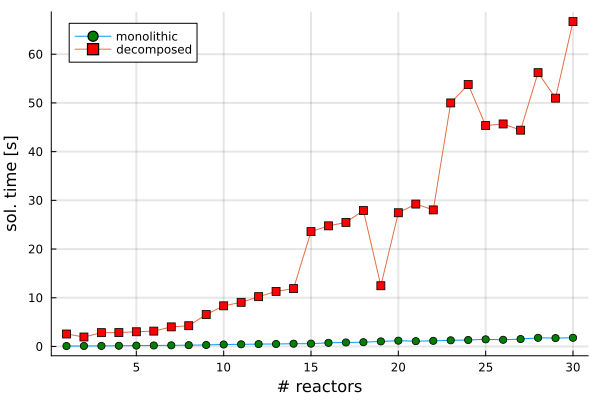

In [33]:
# solution time
p5 = plot(1:nReactMax,solTimeTraj_r[1,:],xlabel="# reactors", ylabel="sol. time [s]",marker=:circle, markercolor = :green,label="monolithic")
p5 = plot!(1:nReactMax,solTimeTraj_r[2,:],marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p5)

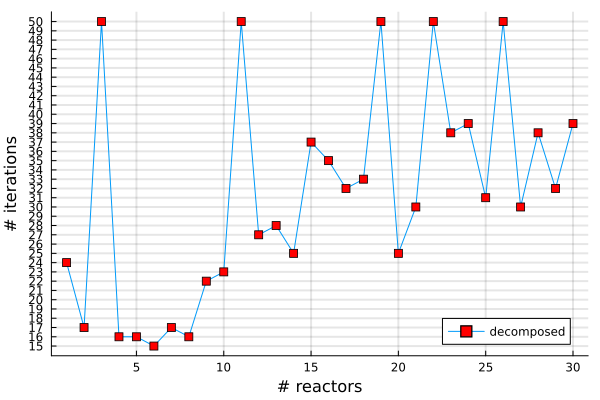

In [34]:
# number of iterations
p6 = plot(1:nReactMax,iterTraj_r,xlabel="# reactors", ylabel="# iterations",yticks=int_ticks(iterTraj_r; step=1),marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p6)

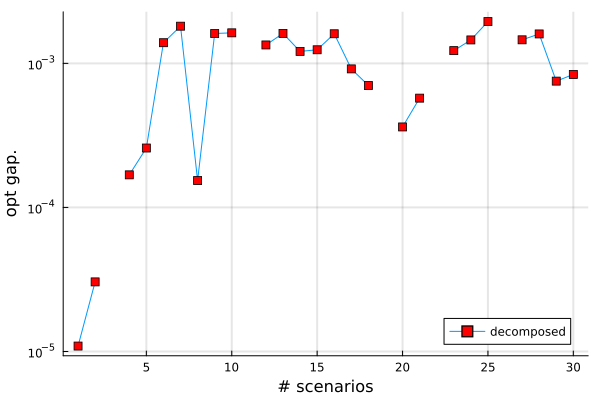

In [35]:
# number of iterations
p8 = plot(1:nReactMax,optGapTraj_r,yscale=:log10,xlabel="# scenarios", ylabel="opt gap.",marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p8)

# Checking if trajectories match for more scenarios and reactors
- arbitrarily chosen number of scenarios and reactors

In [36]:
nSCheck = 3 # number of scenarios
nRCheck = 5 # number of reactors in parallel
optiCheck = opti

# Extracting solution for plotting --> monolithic vs. decomposed 
yTraj = Array{Float64}(undef,2,pD,nSCheck)
uTraj = Array{Float64}(undef,2,pD,nSCheck) 
yspTraj = Array{Float64}(undef,2,pD,nSCheck) 

#equiprobable scenarios
pScheck = 1.0/nSCheck;

# Number of states
nx = 2*nRCheck;

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nRCheck,1]);
uInit_0 = 1.0 - u0;

sol_mon = MS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,optiCheck)
sol_dec = BENS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,optiCheck)

for ii in 1:pD
    for ss in 1:nSCheck
    # transforming from deviation form
    yTraj[1,ii,ss] = sol_mon['y'][ii,ss] + y0
    yspTraj[1,ii,ss] = sol_mon['s'][ii,ss] + y0
    uTraj[1,ii,ss] = sol_mon['u'][ii,1,ss] + u0
        
    yTraj[2,ii,ss] = sol_dec['y'][ss][ii] + y0
    yspTraj[2,ii,ss] = sol_dec['s'][ss][ii] + y0
    uTraj[2,ii,ss] = sol_dec['u'][ss][1,ii] + u0    
    end
end;

" DB: opt gap = 3.523038639157175"

">>>>>> iteration 1:O"

" DB: opt gap = 2.0550624140954157"

">>>>>> iteration 2:O"

" DB: opt gap = 2.0583584523840517"

">>>>>> iteration 3:O"

" DB: opt gap = 2.2566509412843385"

">>>>>> iteration 4:O"

" DB: opt gap = 1.2254369643519372"

">>>>>> iteration 5:O"

" DB: opt gap = 1.2622188089766397"

">>>>>> iteration 6:O"

" DB: opt gap = 1.3148908025875021"

">>>>>> iteration 7:O"

" DB: opt gap = 1.5237364037693455"

">>>>>> iteration 8:O"

" DB: opt gap = 1.011691781397135"

">>>>>> iteration 9:O"

" DB: opt gap = 0.03592036120179017"

">>>>>> iteration 10:O"

" DB: opt gap = 0.03673688137135788"

">>>>>> iteration 11:O"

" DB: opt gap = 0.03606794167180663"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.03513142501695429"

">>>>>> iteration 14:O"

" DB: opt gap = 0.03505280056542368"

">>>>>> iteration 15:O"

" DB: opt gap = 0.03570290745503999"

">>>>>> iteration 16:O"

" DB: opt gap = 0.03339847632460867"

">>>>>> iteration 17:O"

" DB: opt gap = 0.0002947895073213313"

In [37]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=nSCheck), 1, nSCheck);
MList =[:cross, :circle];

Plot Recipe

In [38]:
@userplot Plot_Comp
@recipe function f(h::Plot_Comp)
        
if length(h.args) < 7
        y_lim, ylab, lineT, x, y, y_ub = h.args
    else
        y_lim, ylab, lineT, x, y, y_ub, y_lb = h.args
    end
    
    # set up the subplots
    # these are common to both marginal histograms
    layout := (3,1)
    grid := true
    gridlinewidth --> 2
    latex := true
    linecolor := :black
    
    for ss = 1:3
        # limits
        ylimits := y_lim
        
        # labels 
        ylabel := ylab
        if ss == 3
            xlabel := "time [min]"
        end
        
        # DATA PLOTTING
        # upper bound
        @series begin
            seriestype := :path
            linestyle := :dot
            subplot := ss
        
            if ss == 1
                label --> "Limit"
            else
                label --> ""
            end
            
            x, y_ub*ones(length(x))
        end

        if length(h.args) > 6 
            # lower bound
            @series begin
                seriestype := :path
                linestyle := :dot
                subplot := ss
                label --> ""
                
                x, y_lb*ones(length(x))
            end
        end

        labels = ["Mono.", "Deco."]
        for mm = 1:2
            # average MC value
            @series begin
                if lineT == 2
                    seriestype := :steppre
                else
                    seriestype := :path
                end
                linewidth := 3
                subplot := ss

                markercolor := :black
                markerstrokecolor := :black
                markersize := 3

                if ss == 1
                    label --> labels[mm]
                else
                    label --> ""
                end

                if mm == 1
                    linestyle := :solid
                    markershape := :circle
                else
                    linestyle := :dashdot
                    markershape := :rect
                end

                x, y[mm,:,ss]
            end
        end
    end # mono/dec loop
end;

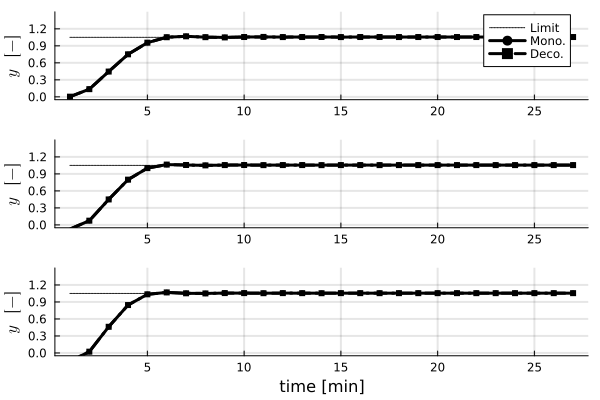

In [46]:
plot_comp((-0.05,1.5),L"y \quad [-]",1,ts,yTraj,(pUB + y0))

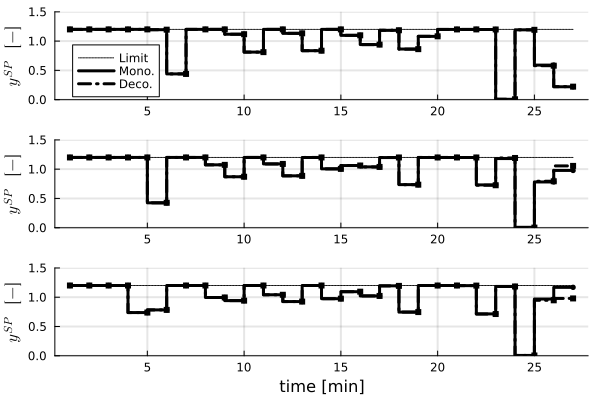

In [45]:
plot_comp((0.0,1.5),L"y^{SP} \quad [-]",2,ts,yspTraj,yspMax)

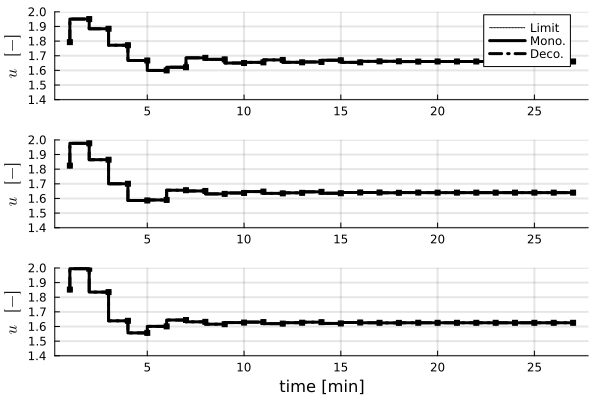

In [41]:
plot_comp((1.4,2.0),L"u \quad [-]",2,ts,uTraj,uMax)

Creating table to show the results

In [42]:
# Scenarios
table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_solMax = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_s[1,tt])
    push!(table_solTime_D, solTimeTraj_s[2,tt])
    push!(table_solMax, solTimeMaxTraj_s[tt])
    push!(table_of_M, solObjTraj_s[1,tt])
    push!(table_of_D, solObjTraj_s[2,tt])
    push!(table_perChange, (solObjTraj_s[2,tt] - solObjTraj_s[1,tt])/solObjTraj_s[1,tt])
end

df_scen = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 sol_time_D_max = table_solMax,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange)

table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_r[1,tt])
    push!(table_solTime_D, solTimeTraj_r[2,tt])
    push!(table_of_M, solObjTraj_r[1,tt])
    push!(table_of_D, solObjTraj_r[2,tt])
    push!(table_perChange, (solObjTraj_r[2,tt] - solObjTraj_r[1,tt])/solObjTraj_r[1,tt])
end

df_reac = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange);

In [43]:
display("Analysis: # of Scenarios")
display(df_scen)

display("Analysis: # of Reactors")
display(df_reac)

"Analysis: # of Scenarios"

Row,iter,sol_time_M,sol_time_D,sol_time_D_max,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any,Any
1,5,0.218,2.203,0.487,-5.56761,-5.56761,4.40144e-7
2,10,0.387,9.645,1.169,-5.56946,-5.56924,-3.94256e-5
3,15,0.574,15.051,1.307,-5.5694,-5.56916,-4.3002e-5
4,20,0.781,22.356,1.519,-5.56951,-5.5695,-1.0179e-6
5,25,0.993,24.327,1.254,-5.56966,-5.56966,-6.78803e-7
6,30,1.18,17.531,0.708,-5.56964,-5.56964,1.17739e-6


"Analysis: # of Reactors"

Row,iter,sol_time_M,sol_time_D,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any
1,5,0.175,3.017,-4.27273,-4.27273,1.1206e-6
2,10,0.407,8.343,-3.09987,-3.0997,-5.53892e-5
3,15,0.576,23.577,-1.84333,-1.84307,-0.000143397
4,20,1.184,27.451,-0.794557,-0.794506,-6.4225e-5
5,25,1.459,45.352,0.293512,0.293924,0.00140468
6,30,1.786,66.708,1.50341,1.50407,0.000442541
